# Model fitting for MetMCC-SCAN
## Yanrong (Jerry) Ji

## TODO:
- build a pipeline for preprocessing
>- further group some levels and compare
>- missing val: imputation/leave as it is
>- more feature engineering?
- bayesian optimization (done)
- merge SEER data
- bagged XGBoost

## Major issues:
- Categorical + Numeric
- Missing values
- Imbalance

In [1]:
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost
# !pip install scikit-optimize
# !pip install imblearn

In [2]:
# general modules
import os
from copy import deepcopy
import pickle as pkl
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn modules
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import accuracy_score,confusion_matrix, auc, roc_auc_score
from sklearn.metrics import roc_curve, f1_score, average_precision_score, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, fbeta_score, make_scorer
from sklearn.impute import KNNImputer

# xgboost,lightgbm,catboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Bayesian optimization
from skopt import BayesSearchCV
from skopt import callbacks
from skopt.space import Real, Integer

# Class imbalance
from imblearn.over_sampling import SMOTENC
from imblearn.ensemble import BalancedRandomForestClassifier

# set seaborn style
sns.set(style='white')
sns.set(style='whitegrid', color_codes=True)
sns.set(font_scale=1.5)

In [3]:
BASE_DIR = os.path.dirname(os.path.realpath('model_fitting')) + '/'

In [3]:
# read in data
mcc_ncdb = pd.read_pickle(BASE_DIR + '../data/Merkel_NCDB_augmented_clean.pkl')

In [5]:
mcc_ncdb.head()

,DEPTH,TUMOR_SIZE,PRIMARY_SITE,AGE,SEX,GROWTH_PATTERN,HISTOLOGY,LATERALITY,LYMPH_VASCULAR_INVASION,TUMOR_INFILTRATING_LYMPHOCYTES,IMMUNE_SUPPRESSION,TUMOR_BASE_TRANSECTION,SLNB,YEAR_SINCE_DIAGNOSIS
8,999.0,10,C444,71,1,999,8247,0,0,999,999,999,0.0,5
12,999.0,999,C447,87,1,999,8247,1,9,999,999,999,1.0,8
14,10.0,2,C443,43,1,999,8247,2,9,0,0,20,0.0,2
19,50.0,25,C447,59,2,999,8247,1,0,999,999,999,0.0,2
21,999.0,30,C446,75,2,999,8247,1,9,999,999,999,1.0,8


## Split data

In [6]:
# subset of features only
mcc_ncdb_sel = mcc_ncdb[['AGE','SEX','PRIMARY_SITE','LYMPH_VASCULAR_INVASION',
                        'TUMOR_SIZE', 'DEPTH', 'TUMOR_INFILTRATING_LYMPHOCYTES',
                        'IMMUNE_SUPPRESSION', 'SLNB'
                       ]]
mcc_ncdb_sel = pd.get_dummies(mcc_ncdb_sel)
X_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns != 'SLNB'])
y_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns == 'SLNB'])
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, y_sel, 
                                                                test_size = 0.1, 
                                                                random_state = 123) # set seed to ensure reproducibility

In [7]:
# all features
mcc_ncdb = pd.get_dummies(mcc_ncdb)
X = np.array(mcc_ncdb.loc[:, mcc_ncdb.columns != 'SLNB'])
y = np.array(mcc_ncdb.loc[:, mcc_ncdb.columns == 'SLNB'])
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.1, 
                                                    random_state = 123) # set seed to ensure reproducibility

In [8]:
X_train.shape

(8901, 48)

In [9]:
X_train_sel.shape

(8901, 32)

In [10]:
mcc_ncdb.columns

Index(['DEPTH', 'TUMOR_SIZE', 'AGE', 'SEX', 'SLNB', 'YEAR_SINCE_DIAGNOSIS',
       'PRIMARY_SITE_C440', 'PRIMARY_SITE_C441', 'PRIMARY_SITE_C442',
       'PRIMARY_SITE_C443', 'PRIMARY_SITE_C444', 'PRIMARY_SITE_C445',
       'PRIMARY_SITE_C446', 'PRIMARY_SITE_C447', 'PRIMARY_SITE_C448',
       'PRIMARY_SITE_C449', 'GROWTH_PATTERN_10.0', 'GROWTH_PATTERN_20.0',
       'GROWTH_PATTERN_999.0', 'HISTOLOGY_8247', 'LATERALITY_0',
       'LATERALITY_1', 'LATERALITY_2', 'LATERALITY_3', 'LATERALITY_4',
       'LATERALITY_5', 'LATERALITY_9', 'LYMPH_VASCULAR_INVASION_0.0',
       'LYMPH_VASCULAR_INVASION_1.0', 'LYMPH_VASCULAR_INVASION_8.0',
       'LYMPH_VASCULAR_INVASION_9.0', 'TUMOR_INFILTRATING_LYMPHOCYTES_0.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_10.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_20.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_30.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_999.0', 'IMMUNE_SUPPRESSION_0.0',
       'IMMUNE_SUPPRESSION_10.0', 'IMMUNE_SUPPRESSION_20.0',
       'IMMUNE_SU

In [11]:
mcc_ncdb_sel.columns

Index(['AGE', 'SEX', 'TUMOR_SIZE', 'DEPTH', 'SLNB', 'PRIMARY_SITE_C440',
       'PRIMARY_SITE_C441', 'PRIMARY_SITE_C442', 'PRIMARY_SITE_C443',
       'PRIMARY_SITE_C444', 'PRIMARY_SITE_C445', 'PRIMARY_SITE_C446',
       'PRIMARY_SITE_C447', 'PRIMARY_SITE_C448', 'PRIMARY_SITE_C449',
       'LYMPH_VASCULAR_INVASION_0.0', 'LYMPH_VASCULAR_INVASION_1.0',
       'LYMPH_VASCULAR_INVASION_8.0', 'LYMPH_VASCULAR_INVASION_9.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_0.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_10.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_20.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_30.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_999.0', 'IMMUNE_SUPPRESSION_0.0',
       'IMMUNE_SUPPRESSION_10.0', 'IMMUNE_SUPPRESSION_20.0',
       'IMMUNE_SUPPRESSION_30.0', 'IMMUNE_SUPPRESSION_40.0',
       'IMMUNE_SUPPRESSION_50.0', 'IMMUNE_SUPPRESSION_60.0',
       'IMMUNE_SUPPRESSION_70.0', 'IMMUNE_SUPPRESSION_999.0'],
      dtype='object')

## Balance dataset by SMOTE

In [14]:
# cat_features_idx = list(range(4,74,1))
cat_features_idx = list(range(5,47,1))
cat_features_idx.append(3)
sm = SMOTENC(random_state=123, categorical_features = cat_features_idx) # set seed to ensure reproducibility
X_train_balanced, y_train_balanced = sm.fit_sample(X_train, y_train.ravel())

# cat_features_idx_sel = list(range(5,31,1))
cat_features_idx_sel = list(range(4,31,1))
cat_features_idx_sel.append(1)
sm_sel = SMOTENC(random_state=123, categorical_features = cat_features_idx_sel) 
X_train_sel_balanced, y_train_sel_balanced = sm_sel.fit_sample(X_train_sel, y_train_sel.ravel())

In [15]:
X_train_balanced.shape

(12906, 48)

In [16]:
X_train_sel_balanced.shape

(12906, 32)

In [4]:
def negative_pred_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN = cm[0][0]
    FN = cm[1][0]
    return TN/(TN+FN)

In [5]:
def adjusted_negative_pred_value(y_true, y_prob, threshold):
    # first get adjusted hard class
    y_pred = np.where(y_prob>threshold, 1, 0)
    cm = confusion_matrix(y_true, y_pred)
    TN = cm[0][0]
    FN = cm[1][0]
    if TN+FN == 0:
        NPV = 0
    else:
        NPV = TN/(TN+FN)
    return NPV

In [6]:
def adjusted_F1_score(y_true, y_prob, threshold):
    # first get adjusted hard class
    y_pred = np.where(y_prob>threshold, 1, 0)
    cm = confusion_matrix(y_true, y_pred)
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = 2*precision*recall/(precision+recall)
    return F1

In [7]:
def adjusted_neg_F1_score(y_true, y_prob, threshold):
    # first get adjusted hard class
    y_pred = np.where(y_prob>threshold, 1, 0)
    cm = confusion_matrix(y_true, y_pred)
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
    if TN+FN == 0:
        NPV = 0
    else:
        NPV = TN/(TN+FN)
    if TN+FP == 0:
        specificity = 0
    else:
        specificity = TN/(TN+FP)
        
    if NPV+specificity == 0:
        F1 = 0
    else:
        F1 = 2*NPV*specificity/(NPV+specificity)
    return F1

In [8]:
def adjusted_neg_Fbeta_score(y_true, y_prob, beta, threshold):
    # first get adjusted hard class
    y_pred = np.where(y_prob>threshold, 1, 0)
    cm = confusion_matrix(y_true, y_pred)
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
    if TN+FN == 0:
        NPV = 0
    else:
        NPV = TN/(TN+FN)
    if TN+FP == 0:
        specificity = 0
    else:
        specificity = TN/(TN+FP)
        
    if NPV+specificity == 0:
        Fb = 0
    else:
        Fb = (1+beta**2)*NPV*specificity/((beta**2)*NPV+specificity)
    return Fb

## logistic regression (selected vars, not binned)

In [18]:
log_clf_sel = LogisticRegression(penalty='none', max_iter=10000)
log_clf_sel.fit(X_train_sel_balanced,y_train_sel_balanced.ravel())
y_prob_sel = np.asarray(log_clf_sel.predict_proba(X_test_sel))
y_pred_sel = np.asarray(log_clf_sel.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print(confusion_matrix(y_test_sel, y_pred_sel))
print("test accuracy: %s" % log_clf_sel.score(X_test_sel, y_test_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

[[424 293]
 [ 81 191]]
test accuracy: 0.621840242669363
test NPV: 0.8396039603960396
test Precision: 0.39462809917355374
test Recall: 0.7022058823529411
test AUC: 0.691955861842645
test F1: 0.5052910052910053
test AUPR: 0.4970586192176576


## logistic regression (all vars, not binned)

In [19]:
log_clf = LogisticRegression(penalty='none', max_iter=10000)
log_clf.fit(X_train_balanced,y_train_balanced.ravel())
y_prob = np.asarray(log_clf.predict_proba(X_test))
y_pred = np.asarray(log_clf.predict(X_test))
y_test = np.asarray(y_test)
print(confusion_matrix(y_test, y_pred))
print("test accuracy: %s" % log_clf.score(X_test, y_test))
print("test NPV: %s" % negative_pred_value(y_test, y_pred))
print("test Precision: %s" % precision_score(y_test, y_pred))
print("test Recall: %s" % recall_score(y_test, y_pred))
print("test AUC: %s" % roc_auc_score(y_test, y_prob[:,1]))
print("test F1: %s" % f1_score(y_test, y_pred))
print("test AUPR: %s" % average_precision_score(y_test, y_prob[:,1]))

[[510 207]
 [110 162]]
test accuracy: 0.679474216380182
test NPV: 0.8225806451612904
test Precision: 0.43902439024390244
test Recall: 0.5955882352941176
test AUC: 0.699139593075724
test F1: 0.5054602184087363
test AUPR: 0.5056718542189866


## Random forest (selected vars, not binned)

In [20]:
# train a random forest classifier
rf_sel = RandomForestClassifier(oob_score=True, 
                                 random_state=123) # set seed to ensure reproducibility
rf_sel.fit(X_train_sel_balanced,y_train_sel_balanced.ravel())
y_prob_sel = np.asarray(rf_sel.predict_proba(X_test_sel))
y_pred_sel = np.asarray(rf_sel.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % rf_sel.score(X_test_sel, y_test_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

test accuracy: 0.6845298281092013
test NPV: 0.7872340425531915
test Precision: 0.4295774647887324
test Recall: 0.4485294117647059
test AUC: 0.6583087209779309
test F1: 0.43884892086330934
test AUPR: 0.4419208475127108


## Random forest (all vars, not binned)

In [21]:
# train a random forest classifier
rf = RandomForestClassifier(oob_score=True, 
                                 random_state=123) # set seed to ensure reproducibility
rf.fit(X_train_balanced,y_train_balanced.ravel())
y_prob = np.asarray(rf.predict_proba(X_test))
y_pred = np.asarray(rf.predict(X_test))
y_test = np.asarray(y_test)
print("test accuracy: %s" % rf.score(X_test, y_test))
print("test NPV: %s" % negative_pred_value(y_test, y_pred))
print("test Precision: %s" % precision_score(y_test, y_pred))
print("test Recall: %s" % recall_score(y_test, y_pred))
print("test AUC: %s" % roc_auc_score(y_test, y_prob[:,1]))
print("test F1: %s" % f1_score(y_test, y_pred))
print("test AUPR: %s" % average_precision_score(y_test, y_prob[:,1]))

test accuracy: 0.7350859453993933
test NPV: 0.7958387516254877
test Precision: 0.5227272727272727
test Recall: 0.4227941176470588
test AUC: 0.6835953523668882
test F1: 0.46747967479674796
test AUPR: 0.4915979608407029


## Random forest (cost-sensitive, all vars, not binned)

In [26]:
# train a random forest classifier
rf = RandomForestClassifier(oob_score=True, 
#                             class_weight={0:1,1:1e3},
                            class_weight='balanced',
                            random_state=42) # set seed to ensure reproducibility
rf.fit(X_train,y_train.ravel())
y_prob = np.asarray(rf.predict_proba(X_test))
y_pred = np.asarray(rf.predict(X_test))
y_test = np.asarray(y_test)
print("test accuracy: %s" % rf.score(X_test, y_test))
print("test NPV: %s" % negative_pred_value(y_test, y_pred))
print("test Precision: %s" % precision_score(y_test, y_pred))
print("test Recall: %s" % recall_score(y_test, y_pred))
print("test AUC: %s" % roc_auc_score(y_test, y_prob[:,1]))
print("test F1: %s" % f1_score(y_test, y_pred))
print("test AUPR: %s" % average_precision_score(y_test, y_prob[:,1]))

test accuracy: 0.7381193124368048
test NPV: 0.7752403846153846
test Precision: 0.5414012738853503
test Recall: 0.3125
test AUC: 0.6944632455492656
test F1: 0.3962703962703963
test AUPR: 0.5009000174810572


## Balanced Random Forest

In [27]:
# train a random forest classifier
rf = BalancedRandomForestClassifier(
                            n_estimators=1000,
                            max_depth=50,
                            max_features = 7,
                            oob_score=True, 
                            random_state=123) # set seed to ensure reproducibility
rf.fit(X_train,y_train.ravel())
y_prob = np.asarray(rf.predict_proba(X_test))
y_pred = np.asarray(rf.predict(X_test))
y_test = np.asarray(y_test)
print("test accuracy: %s" % rf.score(X_test, y_test))
print("test NPV: %s" % negative_pred_value(y_test, y_pred))
print("test Precision: %s" % precision_score(y_test, y_pred))
print("test Recall: %s" % recall_score(y_test, y_pred))
print("test AUC: %s" % roc_auc_score(y_test, y_prob[:,1]))
print("test F1: %s" % f1_score(y_test, y_pred))
print("test AUPR: %s" % average_precision_score(y_test, y_prob[:,1]))

test accuracy: 0.6572295247724975
test NPV: 0.8247422680412371
test Precision: 0.4176904176904177
test Recall: 0.625
test AUC: 0.7064668963819838
test F1: 0.5007363770250368
test AUPR: 0.5200822136231125


## Bayesian optimization: RF (all vars, not binned)

In [28]:
# # RandomForest + Bayesian optimization
# opt_rf = BayesSearchCV(BalancedRandomForestClassifier(oob_score=True,
#                                      random_state=123),
#                        {
#                         'n_estimators': (100,2000),
#                         'max_depth': (5, 100),  
#                         'criterion': ['gini','entropy'],
#                         'max_features': (1, 75),
#                        }, 
#                         n_iter = 20, verbose = 5, n_jobs=6)

# # callback handler
# def on_step(optim_result):
#     score = opt_rf.best_score_
#     print("best score: %s" % score)
# #     with open("./rf_checkpoint.pkl", 'wb') as pickle_file:
# #         pkl.dump(opt_rf, pickle_file)
#     if score >= 0.95:
#         print('Interrupting...')
#         return True
    
# opt_rf.fit(X_train, y_train.ravel(), callback=[on_step])

# print("best parameter set: %s" % opt_rf.best_params_)
# print("val. score: %s" % opt_rf.best_score_)
# # print("test score: %s" % opt_rf.score(X_test, y_test))
# y_prob = np.asarray(opt_rf.predict_proba(X_test))
# y_pred = np.asarray(opt_rf.predict(X_test))
# y_test = np.asarray(y_test)
# print("test accuracy: %s" % opt_rf.score(X_test, y_test))
# print("test NPV: %s" % negative_pred_value(y_test, y_pred))
# print("test Precision: %s" % precision_score(y_test, y_pred))
# print("test Recall: %s" % recall_score(y_test, y_pred))
# print("test AUC: %s" % roc_auc_score(y_test, y_prob[:,1]))
# print("test F1: %s" % f1_score(y_test, y_pred))
# print("test AUPR: %s" % average_precision_score(y_test, y_prob[:,1]))

In [49]:
# train a random forest classifier
rf = BalancedRandomForestClassifier(
                            n_estimators=677,
                            max_depth=5,
                            max_features = 12,
                            criterion = 'entropy',
                            oob_score=True, 
                            random_state=123) # set seed to ensure reproducibility
rf.fit(X_train,y_train.ravel())
y_prob = np.asarray(rf.predict_proba(X_test))
y_pred = np.asarray(rf.predict(X_test))
y_test = np.asarray(y_test)
print("test accuracy: %s" % rf.score(X_test, y_test))
print("test NPV: %s" % negative_pred_value(y_test, y_pred))
print("test Precision: %s" % precision_score(y_test, y_pred))
print("test Recall: %s" % recall_score(y_test, y_pred))
print("test AUC: %s" % roc_auc_score(y_test, y_prob[:,1]))
print("test F1: %s" % f1_score(y_test, y_pred))
print("test AUPR: %s" % average_precision_score(y_test, y_prob[:,1]))

test accuracy: 0.6760772659732541
test NPV: 0.9382151029748284
test Precision: 0.1906779661016949
test Recall: 0.625
test AUC: 0.7023941578850065
test F1: 0.2922077922077922
test AUPR: 0.20623990892095453


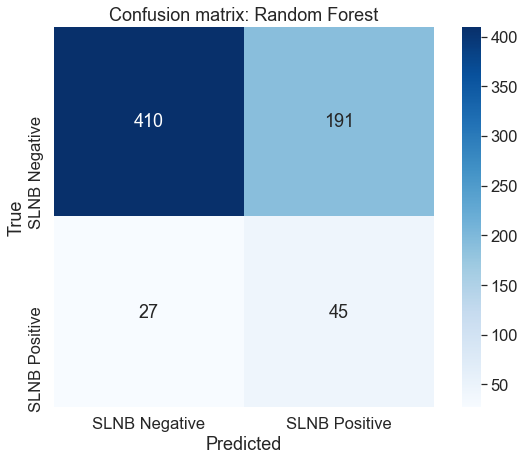

In [47]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in ["SLNB Negative","SLNB Positive"]],
                  columns = [i for i in ["SLNB Negative","SLNB Positive"]])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True, cmap='Blues',square=True, fmt='d').set_title('Confusion matrix: Random Forest')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [51]:
with open(BASE_DIR+'../model/balanced_rf.pkl', 'wb') as f:
    pkl.dump(rf, f)

## Binning the columns

In [29]:
# read in data
mcc_ncdb = pd.read_pickle(BASE_DIR + '../data/Merkel_NCDB_augmented_clean.pkl')
# subset of features only
mcc_ncdb_sel = mcc_ncdb[['AGE','SEX','PRIMARY_SITE',
                        'TUMOR_SIZE', 'DEPTH', 
                        'LYMPH_VASCULAR_INVASION', 
                        'TUMOR_INFILTRATING_LYMPHOCYTES',
                        'IMMUNE_SUPPRESSION', 
                        'GROWTH_PATTERN',
                        'TUMOR_BASE_TRANSECTION',
                        'SLNB'
                       ]]


In [30]:
mcc_ncdb_sel.head()

,AGE,SEX,PRIMARY_SITE,TUMOR_SIZE,DEPTH,LYMPH_VASCULAR_INVASION,TUMOR_INFILTRATING_LYMPHOCYTES,IMMUNE_SUPPRESSION,GROWTH_PATTERN,TUMOR_BASE_TRANSECTION,SLNB
8,71,1,C444,10,999.0,0,999,999,999,999,0.0
12,87,1,C447,999,999.0,9,999,999,999,999,1.0
14,43,1,C443,2,10.0,9,0,0,999,20,0.0
19,59,2,C447,25,50.0,0,999,999,999,999,0.0
21,75,2,C446,30,999.0,9,999,999,999,999,1.0


In [31]:
mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'].value_counts()

999.0    7217
10.0     1159
20.0      988
0.0       526
Name: TUMOR_BASE_TRANSECTION, dtype: int64

In [32]:
# binning the categories
mcc_ncdb_sel['SEX'] = mcc_ncdb_sel['SEX'].replace([1, 2],
                                                ['Male', 'Female']
                                               )
mcc_ncdb_sel['PRIMARY_SITE'] = mcc_ncdb_sel['PRIMARY_SITE'].replace(['C440','C441','C442','C443',
                                                                     'C444','C445','C446','C447',
                                                                     'C448','C449'],
                                                                    ['Head_and_Neck',
                                                                     'Head_and_Neck',
                                                                     'Head_and_Neck',
                                                                     'Other',
                                                                     'Head_and_Neck',
                                                                     'Trunk',
                                                                     'Extremity',
                                                                     'Extremity',
                                                                     'Other',
                                                                     'Other']
                                                                   )
mcc_ncdb_sel['LYMPH_VASCULAR_INVASION'] = mcc_ncdb_sel['LYMPH_VASCULAR_INVASION'].replace([0, 1, 8, 9],
                                                                                          ['No',
                                                                                           'Yes',
                                                                                           'Unknown',
                                                                                           'Unknown'
                                                                                          ])
mcc_ncdb_sel['TUMOR_INFILTRATING_LYMPHOCYTES'] = mcc_ncdb_sel['TUMOR_INFILTRATING_LYMPHOCYTES'].replace(
                                                                                          [0, 1, 20, 30, 999],
                                                                                          ['Negative',
                                                                                           'Weak',
                                                                                           'Strong',
                                                                                           'Present',
                                                                                           'Unknown'
                                                                                          ])
mcc_ncdb_sel['IMMUNE_SUPPRESSION'] = mcc_ncdb_sel['IMMUNE_SUPPRESSION'].replace(
                                                                              [0, 1, 20, 30, 40,
                                                                               50, 60, 70, 999],
                                                                              ['Negative',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Unknown'
                                                                              ])
mcc_ncdb_sel['GROWTH_PATTERN'] = mcc_ncdb_sel['GROWTH_PATTERN'].replace([1, 20, 999],
                                                                          ['Circumscribed_nodular',
                                                                           'Diffusely_infiltrative',
                                                                           'Unknown'])

mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'] = mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'].replace([0, 1, 20, 999],
                                                                                          ['Not_found',
                                                                                           'Transected',
                                                                                           'Not_transected',
                                                                                           'Unknown'
                                                                                          ])

/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a cop

## Imputing DEPTH and TUMOR_SIZE to be zero

In [33]:
mcc_ncdb_sel['DEPTH'] = mcc_ncdb_sel['DEPTH'].replace([999],[0])
mcc_ncdb_sel['TUMOR_SIZE'] = mcc_ncdb_sel['TUMOR_SIZE'].replace([999],[0])

/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [34]:
mcc_ncdb_sel.head()

,AGE,SEX,PRIMARY_SITE,TUMOR_SIZE,DEPTH,LYMPH_VASCULAR_INVASION,TUMOR_INFILTRATING_LYMPHOCYTES,IMMUNE_SUPPRESSION,GROWTH_PATTERN,TUMOR_BASE_TRANSECTION,SLNB
8,71,Male,Head_and_Neck,10,0.0,No,Unknown,Unknown,Unknown,Unknown,0.0
12,87,Male,Extremity,0,0.0,Unknown,Unknown,Unknown,Unknown,Unknown,1.0
14,43,Male,Other,2,10.0,Unknown,Negative,Negative,Unknown,Not_transected,0.0
19,59,Female,Extremity,25,50.0,No,Unknown,Unknown,Unknown,Unknown,0.0
21,75,Female,Extremity,30,0.0,Unknown,Unknown,Unknown,Unknown,Unknown,1.0


In [35]:
mcc_ncdb_sel.TUMOR_SIZE.value_counts()

0      2041
10      574
15      468
20      424
992     407
       ... 
270       1
180       1
148       1
108       1
220       1
Name: TUMOR_SIZE, Length: 132, dtype: int64

In [36]:
# save cleaned data
mcc_ncdb_sel.to_csv(BASE_DIR+"../data/Merkel_NCDB_augmented_clean_selectedVars.csv")
mcc_ncdb_sel.to_pickle(BASE_DIR+"../data/Merkel_NCDB_augmented_clean_selectedVars.pkl")

In [37]:
mcc_ncdb_sel = pd.get_dummies(mcc_ncdb_sel)
X_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns != 'SLNB'])
y_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns == 'SLNB'])
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, y_sel, 
                                                                test_size = 0.1, 
                                                                random_state = 123) # set seed to ensure reproducibility

In [38]:
X_train_sel.shape

(8901, 28)

In [39]:
mcc_ncdb_sel.columns

Index(['AGE', 'TUMOR_SIZE', 'DEPTH', 'SLNB', 'SEX_Female', 'SEX_Male',
       'PRIMARY_SITE_Extremity', 'PRIMARY_SITE_Head_and_Neck',
       'PRIMARY_SITE_Other', 'PRIMARY_SITE_Trunk',
       'LYMPH_VASCULAR_INVASION_No', 'LYMPH_VASCULAR_INVASION_Unknown',
       'LYMPH_VASCULAR_INVASION_Yes', 'TUMOR_INFILTRATING_LYMPHOCYTES_10.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Negative',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Present',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Strong',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Unknown', 'IMMUNE_SUPPRESSION_10.0',
       'IMMUNE_SUPPRESSION_Negative', 'IMMUNE_SUPPRESSION_Positive',
       'IMMUNE_SUPPRESSION_Unknown', 'GROWTH_PATTERN_10.0',
       'GROWTH_PATTERN_Diffusely_infiltrative', 'GROWTH_PATTERN_Unknown',
       'TUMOR_BASE_TRANSECTION_10.0', 'TUMOR_BASE_TRANSECTION_Not_found',
       'TUMOR_BASE_TRANSECTION_Not_transected',
       'TUMOR_BASE_TRANSECTION_Unknown'],
      dtype='object')

In [40]:
# train a random forest classifier
rf = BalancedRandomForestClassifier(
                            n_estimators=1000,
                            max_depth=50,
                            max_features = 7,
                            oob_score=True, 
                            random_state=123) # set seed to ensure reproducibility
rf.fit(X_train_sel,y_train_sel.ravel())
y_prob_sel = np.asarray(rf.predict_proba(X_test_sel))
y_pred_sel = np.asarray(rf.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % accuracy_score(y_test_sel, y_pred_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

test accuracy: 0.6228513650151668
test NPV: 0.8127272727272727
test Precision: 0.38496583143507973
test Recall: 0.6213235294117647
test AUC: 0.6747220854869144
test F1: 0.4753867791842476
test AUPR: 0.42123272915015514


In [28]:
# RandomForest + Bayesian optimization
opt_rf = BayesSearchCV(BalancedRandomForestClassifier(oob_score=True,
                                     random_state=123),
                       {
                        'n_estimators': (100,2000),
                        'max_depth': (5, 100),  
                        'criterion': ['gini','entropy'],
                        'max_features': (1, 27),
                       }, 
                        n_iter = 20, verbose = 5, 
                       scoring=make_scorer(f1_score),
                       n_jobs=6)

# callback handler
def on_step(optim_result):
    score = opt_rf.best_score_
    print("best score: %s" % score)
#     with open("./rf_checkpoint.pkl", 'wb') as pickle_file:
#         pkl.dump(opt_rf, pickle_file)
    if score >= 0.99:
        print('Interrupting...')
        return True
    
opt_rf.fit(X_train_sel, y_train_sel.ravel(), callback=[on_step])

print("best parameter set: %s" % opt_rf.best_params_)
print("val. score: %s" % opt_rf.best_score_)
# print("test score: %s" % opt_rf.score(X_test, y_test))
y_prob_sel = np.asarray(opt_rf.predict_proba(X_test_sel))
y_pred_sel = np.asarray(opt_rf.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % accuracy_score(y_test_sel, y_pred_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    6.4s remaining:    9.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    6.4s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.29357736638841975
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   10.5s remaining:   15.7s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   10.6s finished


best score: 0.29357736638841975
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    5.7s remaining:    8.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    5.8s finished


best score: 0.29357736638841975
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   17.5s remaining:   26.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   17.7s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.29357736638841975
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    6.4s remaining:    9.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    6.5s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.29749733422600366
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   11.9s remaining:   17.9s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   12.1s finished


best score: 0.29749733422600366
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   23.2s remaining:   34.8s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   23.7s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.29749733422600366
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   18.0s remaining:   26.9s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   18.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.29749733422600366
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   23.4s remaining:   35.1s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   23.4s finished


best score: 0.2992359104983263
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   20.5s remaining:   30.7s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   20.6s finished


best score: 0.2992359104983263
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   20.8s remaining:   31.1s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   20.9s finished


best score: 0.2992359104983263
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    6.2s remaining:    9.3s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    6.3s finished


best score: 0.2992359104983263
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    6.3s remaining:    9.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    6.3s finished


best score: 0.2992359104983263
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    1.1s finished


best score: 0.2992359104983263
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    9.1s remaining:   13.7s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    9.3s finished


best score: 0.3047739028383401
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   16.7s remaining:   25.0s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   16.8s finished


best score: 0.3064860722534881
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.9s finished


best score: 0.3064860722534881
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   17.3s remaining:   26.0s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   17.5s finished


best score: 0.3064860722534881
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    1.3s remaining:    1.9s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    1.3s finished


best score: 0.3064860722534881
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   21.4s remaining:   32.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   21.5s finished


best score: 0.3064860722534881
best parameter set: OrderedDict([('criterion', 'gini'), ('max_depth', 5), ('max_features', 24), ('n_estimators', 2250)])
val. score: 0.3064860722534881
test accuracy: 0.6264274061990212
test NPV: 0.8844086021505376
test Precision: 0.22821576763485477
test Recall: 0.5612244897959183
test AUC: 0.6533584307509412
test F1: 0.3244837758112094
test AUPR: 0.3379450087365217


In [21]:
# def adjusted_classes(y_scores, t):
#     """
#     This function adjusts class predictions based on the prediction threshold (t).
#     Will only work for binary classification problems.
#     Credit to: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65#:~:text=The%20default%20threshold%20for%20RandomForestClassifier,the%20class%20probabilites%20called%20y_scores%20.
#     """
#     return np.asarray([1 if y >= t else 0 for y in y_scores])

# def precision_recall_threshold(p, r, thresholds, t=0.5):
#     """
#     plots the precision recall curve and shows the current value for each
#     by identifying the classifier's threshold (t).
#     """
    
#     # generate new class predictions based on the adjusted_classes
#     # function above and view the resulting confusion matrix.
#     y_pred_adj = adjusted_classes(y_scores, t)
#     print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
#                        columns=['pred_neg', 'pred_pos'], 
#                        index=['neg', 'pos']))
    
#     # plot the curve
#     plt.figure(figsize=(8,8))
#     plt.title("Precision and Recall curve ^ = current threshold")
#     plt.step(r, p, color='b', alpha=0.2,
#              where='post')
#     plt.fill_between(r, p, step='post', alpha=0.2,
#                      color='b')
#     plt.ylim([0.5, 1.01]);
#     plt.xlim([0.5, 1.01]);
#     plt.xlabel('Recall');
#     plt.ylabel('Precision');
    
#     # plot the current threshold on the line
#     close_default_clf = np.argmin(np.abs(thresholds - t))
#     plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
#             markersize=15)

In [22]:
# decision threshold
# t = len(mcc_ncdb_sel[mcc_ncdb_sel['SLNB'] == 0])/(len(mcc_ncdb_sel[mcc_ncdb_sel['SLNB'] == 0]) + \
#                                                   len(mcc_ncdb_sel[mcc_ncdb_sel['SLNB'] == 1]))
# t = 0.56

In [23]:
# train a random forest classifier
rf = BalancedRandomForestClassifier(
                            n_estimators=1033,#1444
                            max_depth=6,#9
                            max_features = 1,#10
                            criterion = 'gini',
                            oob_score=True, 
                            random_state=123) # set seed to ensure reproducibility
rf.fit(X_train_sel,y_train_sel.ravel())

y_prob_sel = np.asarray(rf.predict_proba(X_test_sel))
y_pred_sel = np.asarray(rf.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % accuracy_score(y_test_sel, y_pred_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

test accuracy: 0.6639477977161501
test NPV: 0.8872180451127819
test Precision: 0.24766355140186916
test Recall: 0.5408163265306123
test AUC: 0.664612641172974
test F1: 0.3397435897435898
test AUPR: 0.3353676606393452


In [24]:
# y_scores = y_prob_sel[:,1]
# p, r, thresholds = precision_recall_curve(y_test_sel, y_scores)
# precision_recall_threshold(p, r, thresholds, 0.56)

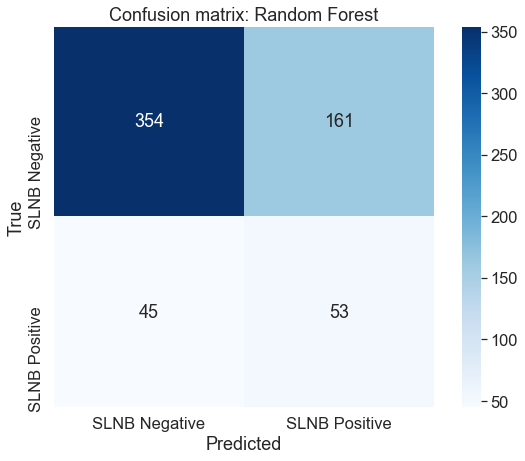

In [25]:
cm = confusion_matrix(y_test_sel, y_pred_sel)
df_cm = pd.DataFrame(cm, index = [i for i in ["SLNB Negative","SLNB Positive"]],
                  columns = [i for i in ["SLNB Negative","SLNB Positive"]])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True, cmap='Blues',square=True, fmt='d').set_title('Confusion matrix: Random Forest')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [29]:
# pickling model
with open(BASE_DIR+'../model/balanced_rf_imputed_binned.pkl', 'wb') as f:
    pkl.dump(rf, f)

## Try different imputation

In [41]:
# read in data
mcc_ncdb = pd.read_pickle(BASE_DIR + '../data/Merkel_NCDB_augmented_clean.pkl')
# subset of features only
mcc_ncdb_sel = mcc_ncdb[['AGE','SEX','PRIMARY_SITE',
                        'TUMOR_SIZE', 'DEPTH', 
                        'LYMPH_VASCULAR_INVASION', 
                        'TUMOR_INFILTRATING_LYMPHOCYTES',
                        'IMMUNE_SUPPRESSION', 
                        'GROWTH_PATTERN',
                        'TUMOR_BASE_TRANSECTION',
                        'SLNB'
                       ]]


In [42]:
mcc_ncdb_sel.head()

,AGE,SEX,PRIMARY_SITE,TUMOR_SIZE,DEPTH,LYMPH_VASCULAR_INVASION,TUMOR_INFILTRATING_LYMPHOCYTES,IMMUNE_SUPPRESSION,GROWTH_PATTERN,TUMOR_BASE_TRANSECTION,SLNB
8,71,1,C444,10,999.0,0,999,999,999,999,0.0
12,87,1,C447,999,999.0,9,999,999,999,999,1.0
14,43,1,C443,2,10.0,9,0,0,999,20,0.0
19,59,2,C447,25,50.0,0,999,999,999,999,0.0
21,75,2,C446,30,999.0,9,999,999,999,999,1.0


In [43]:
mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'].value_counts()

999.0    7217
10.0     1159
20.0      988
0.0       526
Name: TUMOR_BASE_TRANSECTION, dtype: int64

In [44]:
# binning the categories
mcc_ncdb_sel['SEX'] = mcc_ncdb_sel['SEX'].replace([1, 2],
                                                ['Male', 'Female']
                                               )
mcc_ncdb_sel['PRIMARY_SITE'] = mcc_ncdb_sel['PRIMARY_SITE'].replace(['C440','C441','C442','C443',
                                                                     'C444','C445','C446','C447',
                                                                     'C448','C449'],
                                                                    ['Head_and_Neck',
                                                                     'Head_and_Neck',
                                                                     'Head_and_Neck',
                                                                     'Other',
                                                                     'Head_and_Neck',
                                                                     'Trunk',
                                                                     'Extremity',
                                                                     'Extremity',
                                                                     'Other',
                                                                     'Other']
                                                                   )
mcc_ncdb_sel['LYMPH_VASCULAR_INVASION'] = mcc_ncdb_sel['LYMPH_VASCULAR_INVASION'].replace([0, 1, 8, 9],
                                                                                          ['No',
                                                                                           'Yes',
                                                                                           'Unknown',
                                                                                           'Unknown'
                                                                                          ])
mcc_ncdb_sel['TUMOR_INFILTRATING_LYMPHOCYTES'] = mcc_ncdb_sel['TUMOR_INFILTRATING_LYMPHOCYTES'].replace(
                                                                                          [0, 1, 20, 30, 999],
                                                                                          ['Negative',
                                                                                           'Weak',
                                                                                           'Strong',
                                                                                           'Present',
                                                                                           'Unknown'
                                                                                          ])
mcc_ncdb_sel['IMMUNE_SUPPRESSION'] = mcc_ncdb_sel['IMMUNE_SUPPRESSION'].replace(
                                                                              [0, 1, 20, 30, 40,
                                                                               50, 60, 70, 999],
                                                                              ['Negative',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Unknown'
                                                                              ])
mcc_ncdb_sel['GROWTH_PATTERN'] = mcc_ncdb_sel['GROWTH_PATTERN'].replace([1, 20, 999],
                                                                          ['Circumscribed_nodular',
                                                                           'Diffusely_infiltrative',
                                                                           'Unknown'])

mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'] = mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'].replace([0, 1, 20, 999],
                                                                                          ['Not_found',
                                                                                           'Transected',
                                                                                           'Not_transected',
                                                                                           'Unknown'
                                                                                          ])

/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [45]:
# store a copy
mcc_ncdb_sel_cp = deepcopy(mcc_ncdb_sel)

## Imputing DEPTH and TUMOR_SIZE using kNN

In [46]:
mcc_ncdb_sel['DEPTH'] = mcc_ncdb_sel['DEPTH'].replace([999],np.NaN)
mcc_ncdb_sel['TUMOR_SIZE'] = mcc_ncdb_sel['TUMOR_SIZE'].replace([999],np.NaN)

/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [47]:
mcc_ncdb_sel.head()

,AGE,SEX,PRIMARY_SITE,TUMOR_SIZE,DEPTH,LYMPH_VASCULAR_INVASION,TUMOR_INFILTRATING_LYMPHOCYTES,IMMUNE_SUPPRESSION,GROWTH_PATTERN,TUMOR_BASE_TRANSECTION,SLNB
8,71,Male,Head_and_Neck,10.0,NaN,No,Unknown,Unknown,Unknown,Unknown,0.0
12,87,Male,Extremity,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown,1.0
14,43,Male,Other,2.0,10.0,Unknown,Negative,Negative,Unknown,Not_transected,0.0
19,59,Female,Extremity,25.0,50.0,No,Unknown,Unknown,Unknown,Unknown,0.0
21,75,Female,Extremity,30.0,NaN,Unknown,Unknown,Unknown,Unknown,Unknown,1.0


In [48]:
mcc_ncdb_sel = pd.get_dummies(mcc_ncdb_sel)
X_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns != 'SLNB'])
y_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns == 'SLNB'])
# impute by KNN
imputer = KNNImputer()
X_sel = imputer.fit_transform(X_sel).round()
# split data
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, y_sel, 
                                                                test_size = 0.1, 
                                                                random_state = 123) # set seed to ensure reproducibility

In [49]:
mcc_ncdb_sel.columns

Index(['AGE', 'TUMOR_SIZE', 'DEPTH', 'SLNB', 'SEX_Female', 'SEX_Male',
       'PRIMARY_SITE_Extremity', 'PRIMARY_SITE_Head_and_Neck',
       'PRIMARY_SITE_Other', 'PRIMARY_SITE_Trunk',
       'LYMPH_VASCULAR_INVASION_No', 'LYMPH_VASCULAR_INVASION_Unknown',
       'LYMPH_VASCULAR_INVASION_Yes', 'TUMOR_INFILTRATING_LYMPHOCYTES_10.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Negative',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Present',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Strong',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Unknown', 'IMMUNE_SUPPRESSION_10.0',
       'IMMUNE_SUPPRESSION_Negative', 'IMMUNE_SUPPRESSION_Positive',
       'IMMUNE_SUPPRESSION_Unknown', 'GROWTH_PATTERN_10.0',
       'GROWTH_PATTERN_Diffusely_infiltrative', 'GROWTH_PATTERN_Unknown',
       'TUMOR_BASE_TRANSECTION_10.0', 'TUMOR_BASE_TRANSECTION_Not_found',
       'TUMOR_BASE_TRANSECTION_Not_transected',
       'TUMOR_BASE_TRANSECTION_Unknown'],
      dtype='object')

In [50]:
# save imputer
with open(BASE_DIR+'../model/knn_imputer_augmented.pkl', 'wb') as f:
    pkl.dump(imputer, f)

In [51]:
mcc_ncdb_sel = pd.DataFrame(np.concatenate([X_sel[:,:3],y_sel,X_sel[:,3:]], axis=1), columns=mcc_ncdb_sel.columns)
mcc_ncdb_sel_notencoded = mcc_ncdb_sel_cp
mcc_ncdb_sel_notencoded['DEPTH'] = mcc_ncdb_sel['DEPTH']
mcc_ncdb_sel_notencoded['TUMOR_SIZE'] = mcc_ncdb_sel['TUMOR_SIZE']

In [52]:
# save cleaned data
mcc_ncdb_sel.to_csv(BASE_DIR+"../data/Merkel_NCDB_augmented_clean_selectedVars_encoded_imputed.csv")
mcc_ncdb_sel.to_pickle(BASE_DIR+"../data/Merkel_NCDB_augmented_clean_selectedVars_encoded_imputed.pkl")
mcc_ncdb_sel_notencoded.to_csv(BASE_DIR+"../data/Merkel_NCDB_augmented_clean_selectedVars_imputed.csv")
mcc_ncdb_sel_notencoded.to_pickle(BASE_DIR+"../data/Merkel_NCDB_augmented_clean_selectedVars_imputed.pkl")

In [53]:
X_train_sel.shape

(8901, 28)

In [54]:
mcc_ncdb_sel.columns

Index(['AGE', 'TUMOR_SIZE', 'DEPTH', 'SLNB', 'SEX_Female', 'SEX_Male',
       'PRIMARY_SITE_Extremity', 'PRIMARY_SITE_Head_and_Neck',
       'PRIMARY_SITE_Other', 'PRIMARY_SITE_Trunk',
       'LYMPH_VASCULAR_INVASION_No', 'LYMPH_VASCULAR_INVASION_Unknown',
       'LYMPH_VASCULAR_INVASION_Yes', 'TUMOR_INFILTRATING_LYMPHOCYTES_10.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Negative',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Present',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Strong',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Unknown', 'IMMUNE_SUPPRESSION_10.0',
       'IMMUNE_SUPPRESSION_Negative', 'IMMUNE_SUPPRESSION_Positive',
       'IMMUNE_SUPPRESSION_Unknown', 'GROWTH_PATTERN_10.0',
       'GROWTH_PATTERN_Diffusely_infiltrative', 'GROWTH_PATTERN_Unknown',
       'TUMOR_BASE_TRANSECTION_10.0', 'TUMOR_BASE_TRANSECTION_Not_found',
       'TUMOR_BASE_TRANSECTION_Not_transected',
       'TUMOR_BASE_TRANSECTION_Unknown'],
      dtype='object')

In [55]:
# train a random forest classifier
rf = BalancedRandomForestClassifier(
                            n_estimators=1000,
                            max_depth=50,
                            max_features = 7,
                            oob_score=True, 
                            random_state=123) # set seed to ensure reproducibility
rf.fit(X_train_sel,y_train_sel.ravel())
y_prob_sel = np.asarray(rf.predict_proba(X_test_sel))
y_pred_sel = np.asarray(rf.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % accuracy_score(y_test_sel, y_pred_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

test accuracy: 0.6329625884732053
test NPV: 0.8062283737024222
test Precision: 0.38929440389294406
test Recall: 0.5882352941176471
test AUC: 0.6765885224382641
test F1: 0.4685212298682284
test AUPR: 0.43203071532291437


In [56]:
# RandomForest + Bayesian optimization
opt_rf = BayesSearchCV(BalancedRandomForestClassifier(oob_score=True,
                                     random_state=123),
                       {
                        'n_estimators': (100,2000),
                        'max_depth': (5, 100),  
                        'criterion': ['gini','entropy'],
                        'max_features': (1, 27),
                       }, 
                        n_iter = 20, verbose = 5, 
                       scoring=make_scorer(f1_score),
                       n_jobs=6)

# callback handler
def on_step(optim_result):
    score = opt_rf.best_score_
    print("best score: %s" % score)
#     with open("./rf_checkpoint.pkl", 'wb') as pickle_file:
#         pkl.dump(opt_rf, pickle_file)
    if score >= 0.5:
        print('Interrupting...')
        return True
    
opt_rf.fit(X_train_sel, y_train_sel.ravel(), callback=[on_step])

print("best parameter set: %s" % opt_rf.best_params_)
print("val. score: %s" % opt_rf.best_score_)
# print("test score: %s" % opt_rf.score(X_test, y_test))
y_prob_sel = np.asarray(opt_rf.predict_proba(X_test_sel))
y_pred_sel = np.asarray(opt_rf.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % accuracy_score(y_test_sel, y_pred_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   41.7s remaining:  1.0min
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   42.2s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.4757765769348422
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   32.8s remaining:   49.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   34.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    6.9s remaining:   10.3s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    6.9s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   22.3s remaining:   33.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   22.7s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   34.1s remaining:   51.1s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   34.5s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   50.2s remaining:  1.3min
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   50.4s finished


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    5.4s remaining:    8.1s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    5.5s finished


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   34.6s remaining:   51.9s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   34.8s finished


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   28.9s remaining:   43.4s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   29.1s finished


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   19.6s remaining:   29.3s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   19.7s finished


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   13.5s remaining:   20.3s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   13.7s finished


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    1.3s remaining:    1.9s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    1.3s finished


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   30.6s remaining:   45.9s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   30.8s finished


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   57.2s remaining:  1.4min
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   57.4s finished


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   35.3s remaining:   52.9s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   35.5s finished


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   57.8s remaining:  1.4min
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   58.0s finished


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.6min
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:  1.1min finished


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.0s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.0s finished


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   44.0s remaining:  1.1min
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   45.5s finished


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   28.2s remaining:   42.3s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   28.5s finished


best score: 0.4927433400189125
best parameter set: OrderedDict([('criterion', 'entropy'), ('max_depth', 8), ('max_features', 9), ('n_estimators', 1493)])
val. score: 0.4927433400189125
test accuracy: 0.6208291203235592
test NPV: 0.8379446640316206
test Precision: 0.39337474120082816
test Recall: 0.6985294117647058
test AUC: 0.6984166051357782
test F1: 0.5033112582781457
test AUPR: 0.46643940164150344


In [21]:
# def adjusted_classes(y_scores, t):
#     """
#     This function adjusts class predictions based on the prediction threshold (t).
#     Will only work for binary classification problems.
#     Credit to: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65#:~:text=The%20default%20threshold%20for%20RandomForestClassifier,the%20class%20probabilites%20called%20y_scores%20.
#     """
#     return np.asarray([1 if y >= t else 0 for y in y_scores])

# def precision_recall_threshold(p, r, thresholds, t=0.5):
#     """
#     plots the precision recall curve and shows the current value for each
#     by identifying the classifier's threshold (t).
#     """
    
#     # generate new class predictions based on the adjusted_classes
#     # function above and view the resulting confusion matrix.
#     y_pred_adj = adjusted_classes(y_scores, t)
#     print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
#                        columns=['pred_neg', 'pred_pos'], 
#                        index=['neg', 'pos']))
    
#     # plot the curve
#     plt.figure(figsize=(8,8))
#     plt.title("Precision and Recall curve ^ = current threshold")
#     plt.step(r, p, color='b', alpha=0.2,
#              where='post')
#     plt.fill_between(r, p, step='post', alpha=0.2,
#                      color='b')
#     plt.ylim([0.5, 1.01]);
#     plt.xlim([0.5, 1.01]);
#     plt.xlabel('Recall');
#     plt.ylabel('Precision');
    
#     # plot the current threshold on the line
#     close_default_clf = np.argmin(np.abs(thresholds - t))
#     plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
#             markersize=15)

In [22]:
# decision threshold
# t = len(mcc_ncdb_sel[mcc_ncdb_sel['SLNB'] == 0])/(len(mcc_ncdb_sel[mcc_ncdb_sel['SLNB'] == 0]) + \
#                                                   len(mcc_ncdb_sel[mcc_ncdb_sel['SLNB'] == 1]))
# t = 0.56

In [57]:
# train a random forest classifier
rf = BalancedRandomForestClassifier(
                            n_estimators=1493,#1444, 1961
                            max_depth=8,#9, 6
                            max_features = 9,#10, 4
                            criterion = 'entropy',
                            oob_score=True, 
                            random_state=123) # set seed to ensure reproducibility
rf.fit(X_train_sel,y_train_sel.ravel())

y_prob_sel = np.asarray(rf.predict_proba(X_test_sel))
y_pred_sel = np.asarray(rf.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % accuracy_score(y_test_sel, y_pred_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

# 0.649, 0.8906, 0.245, 0.571, 0.668, 0.343, 0.346

test accuracy: 0.6208291203235592
test NPV: 0.8379446640316206
test Precision: 0.39337474120082816
test Recall: 0.6985294117647058
test AUC: 0.6984166051357782
test F1: 0.5033112582781457
test AUPR: 0.46643940164150344


In [92]:
# y_scores = y_prob_sel[:,1]
# p, r, thresholds = precision_recall_curve(y_test_sel, y_scores)
# precision_recall_threshold(p, r, thresholds, 0.56)

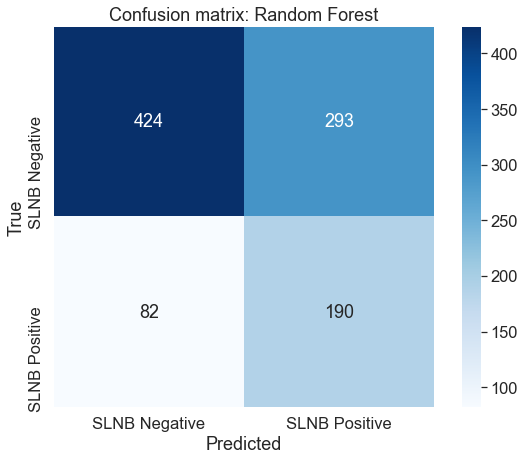

In [58]:
cm = confusion_matrix(y_test_sel, y_pred_sel)
df_cm = pd.DataFrame(cm, index = [i for i in ["SLNB Negative","SLNB Positive"]],
                  columns = [i for i in ["SLNB Negative","SLNB Positive"]])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True, cmap='Blues',square=True, fmt='d').set_title('Confusion matrix: Random Forest')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig(BASE_DIR+'../image/confusion_matrix.pdf')

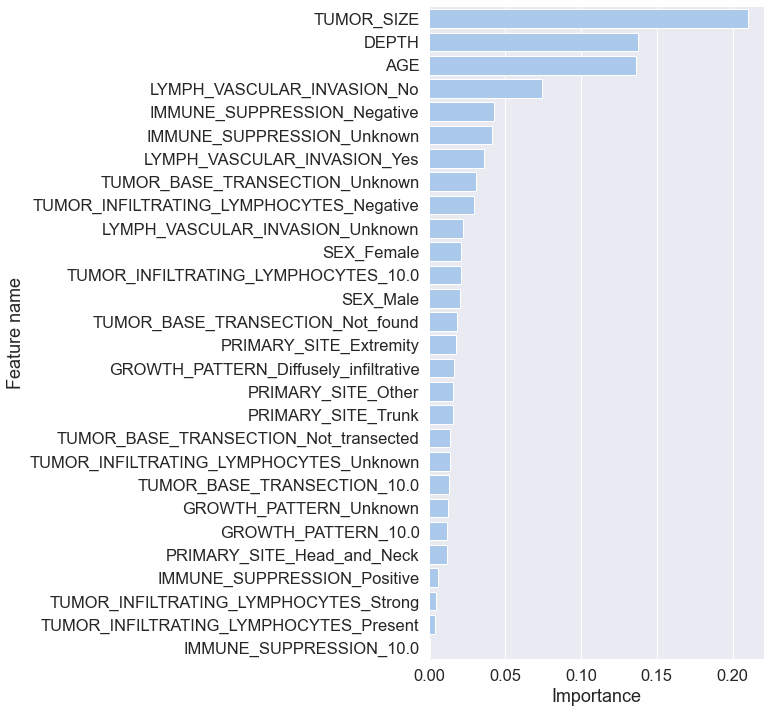

In [59]:
# feature importance
# importances = forest.feature_importances_
# std = np.std([tree.feature_importances_ for tree in forest.estimators_],
#              axis=0)
# indices = np.argsort(importances)[::-1]

# # Print the feature ranking
# print("Feature ranking:")

# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

#mcc_ncdb_sel.drop(['SLNB'], axis=1).columns
# feature importances
imp = rf.feature_importances_
imp_df = pd.DataFrame(data={"Feature name": mcc_ncdb_sel.drop(['SLNB'], axis=1).columns,
                      "Importance": imp}
                     ).sort_values("Importance", ascending=False)

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 12))
sns.set_color_codes("pastel")
sns.barplot(x="Importance", y="Feature name", data=imp_df, color="b")
sns.despine(left=True, bottom=True)
plt.savefig(BASE_DIR+'../image/feature_importance.png', bbox_inches='tight')

In [60]:
# pickling model
with open(BASE_DIR+'../model/balanced_rf_augmented_knnimputed_binned.pkl', 'wb') as f:
    pkl.dump(rf, f)

## Try removing all rows with many missing value

In [156]:
# read in data
mcc_ncdb = pd.read_pickle(BASE_DIR + '../data/Merkel_NCDB_augmented_clean.pkl')
# subset of features only
mcc_ncdb_sel = mcc_ncdb[['AGE','SEX','PRIMARY_SITE',
                        'TUMOR_SIZE', 'DEPTH', 
                        'LYMPH_VASCULAR_INVASION', 
                        'TUMOR_INFILTRATING_LYMPHOCYTES',
                        'IMMUNE_SUPPRESSION', 
                        'GROWTH_PATTERN',
                        'TUMOR_BASE_TRANSECTION',
                        'SLNB'
                       ]]


In [157]:
mcc_ncdb_sel.head()

,AGE,SEX,PRIMARY_SITE,TUMOR_SIZE,DEPTH,LYMPH_VASCULAR_INVASION,TUMOR_INFILTRATING_LYMPHOCYTES,IMMUNE_SUPPRESSION,GROWTH_PATTERN,TUMOR_BASE_TRANSECTION,SLNB
8,71,1,C444,10,999.0,0,999,999,999,999,0.0
12,87,1,C447,999,999.0,9,999,999,999,999,1.0
14,43,1,C443,2,10.0,9,0,0,999,20,0.0
19,59,2,C447,25,50.0,0,999,999,999,999,0.0
21,75,2,C446,30,999.0,9,999,999,999,999,1.0


In [158]:
mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'].value_counts()

999.0    7217
10.0     1159
20.0      988
0.0       526
Name: TUMOR_BASE_TRANSECTION, dtype: int64

In [159]:
# binning the categories
mcc_ncdb_sel['SEX'] = mcc_ncdb_sel['SEX'].replace([1, 2],
#                                                 ['Male', 'Female']
                                                  [0,1]
                                               )
mcc_ncdb_sel['PRIMARY_SITE'] = mcc_ncdb_sel['PRIMARY_SITE'].replace(['C440','C441','C442','C443',
                                                                     'C444','C445','C446','C447',
                                                                     'C448','C449'],
                                                                    ['Head_and_Neck',
                                                                     'Head_and_Neck',
                                                                     'Head_and_Neck',
                                                                     'Other',
                                                                     'Head_and_Neck',
                                                                     'Trunk',
                                                                     'Extremity',
                                                                     'Extremity',
                                                                     'Other',
                                                                     'Other']
#                                                                     [0,0,0,3,0,1,2,2,3,3]
                                                                   )
mcc_ncdb_sel['LYMPH_VASCULAR_INVASION'] = mcc_ncdb_sel['LYMPH_VASCULAR_INVASION'].replace([0, 1, 8, 9],
                                                                                          ['No',
                                                                                           'Yes',
                                                                                           np.nan,
                                                                                           np.nan
                                                                                          ]
#                                                                                          [0,1,np.nan,np.nan]
                                                                                         )
mcc_ncdb_sel['TUMOR_INFILTRATING_LYMPHOCYTES'] = mcc_ncdb_sel['TUMOR_INFILTRATING_LYMPHOCYTES'].replace(
                                                                                          [0, 10, 20, 30, 999],
                                                                                          ['Negative',
                                                                                           'Weak',
                                                                                           'Strong',
                                                                                           'Present',
                                                                                           np.nan
                                                                                          ]
#                                                                                         [0,1,2,3,np.nan]
                                                                                        )
mcc_ncdb_sel['IMMUNE_SUPPRESSION'] = mcc_ncdb_sel['IMMUNE_SUPPRESSION'].replace(
                                                                              [0, 10, 20, 30, 40,
                                                                               50, 60, 70, 999],
                                                                              ['Negative',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               np.nan
                                                                              ]
#                                                                                 [0,1,1,1,1,1,1,1,np.nan]
                                                                            )
mcc_ncdb_sel['GROWTH_PATTERN'] = mcc_ncdb_sel['GROWTH_PATTERN'].replace([10, 20, 999],
                                                                          ['Circumscribed_nodular',
                                                                           'Diffusely_infiltrative',
                                                                           np.nan]
#                                                                         [0,1,np.nan]
                                                                        )

mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'] = mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'].replace([0, 10, 20, 999],
                                                                                          ['Not_found',
                                                                                           'Transected',
                                                                                           'Not_transected',
                                                                                           np.nan
                                                                                          ]
#                                                                                         [0,1,2,np.nan]
                                                                                       )

mcc_ncdb_sel['DEPTH'] = mcc_ncdb_sel['DEPTH'].replace([999],np.nan)
mcc_ncdb_sel['TUMOR_SIZE'] = mcc_ncdb_sel['TUMOR_SIZE'].replace([999],np.nan)

/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [160]:
# store a copy
mcc_ncdb_sel_cp = deepcopy(mcc_ncdb_sel)

In [161]:
mcc_ncdb_sel

,AGE,SEX,PRIMARY_SITE,TUMOR_SIZE,DEPTH,LYMPH_VASCULAR_INVASION,TUMOR_INFILTRATING_LYMPHOCYTES,IMMUNE_SUPPRESSION,GROWTH_PATTERN,TUMOR_BASE_TRANSECTION,SLNB
8,71,0,Head_and_Neck,10.0,NaN,No,NaN,NaN,NaN,NaN,0.0
12,87,0,Extremity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
14,43,0,Other,2.0,10.0,NaN,Negative,Negative,NaN,Not_transected,0.0
19,59,1,Extremity,25.0,50.0,No,NaN,NaN,NaN,NaN,0.0
21,75,1,Extremity,30.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...
34554,39,1,Extremity,NaN,NaN,No,NaN,NaN,NaN,NaN,0.0
34677,35,0,Other,5.0,NaN,Yes,NaN,Negative,NaN,Transected,0.0
34683,34,1,Other,16.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
34738,37,0,Head_and_Neck,29.0,16.0,Yes,Negative,NaN,Circumscribed_nodular,Transected,0.0


## Count how many rows have missing value in all except AGE, SEX, PRIMARY_SITE, SLNB (indicating that they are not useful at all)

In [162]:
# mcc_ncdb_sel_count = mcc_ncdb_sel.drop(['AGE','SEX','PRIMARY_SITE','SLNB'], axis=1)
# mcc_ncdb_sel.drop(mcc_ncdb_sel_count.index[mcc_ncdb_sel_count.isnull().all(1)], axis=0)
# mcc_ncdb_sel.dropna(thresh=7)
print(mcc_ncdb_sel.dropna(thresh=6).SLNB.value_counts()) # make threshold = 6 i.e. at max 5 NaN
mcc_ncdb_sel.dropna(thresh=6, inplace=True)

0.0    4394
1.0    1146
Name: SLNB, dtype: int64


/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [164]:
mcc_ncdb_sel['LYMPH_VASCULAR_INVASION'] = mcc_ncdb_sel['LYMPH_VASCULAR_INVASION'].fillna('Unknown')
mcc_ncdb_sel['TUMOR_INFILTRATING_LYMPHOCYTES'] = mcc_ncdb_sel['TUMOR_INFILTRATING_LYMPHOCYTES'].fillna('Unknown')
mcc_ncdb_sel['IMMUNE_SUPPRESSION'] = mcc_ncdb_sel['IMMUNE_SUPPRESSION'].fillna('Unknown')
mcc_ncdb_sel['GROWTH_PATTERN'] = mcc_ncdb_sel['GROWTH_PATTERN'].fillna('Unknown')
mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'] = mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'].fillna('Unknown')

/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


## Imputing TUMOR_SIZE and DEPTH using kNN

In [165]:
mcc_ncdb_sel.head()

,AGE,SEX,PRIMARY_SITE,TUMOR_SIZE,DEPTH,LYMPH_VASCULAR_INVASION,TUMOR_INFILTRATING_LYMPHOCYTES,IMMUNE_SUPPRESSION,GROWTH_PATTERN,TUMOR_BASE_TRANSECTION,SLNB
8,71,0,Head_and_Neck,10.0,NaN,No,Unknown,Unknown,Unknown,Unknown,0.0
14,43,0,Other,2.0,10.0,Unknown,Negative,Negative,Unknown,Not_transected,0.0
19,59,1,Extremity,25.0,50.0,No,Unknown,Unknown,Unknown,Unknown,0.0
23,82,1,Other,14.0,NaN,No,Unknown,Negative,Circumscribed_nodular,Not_transected,0.0
31,90,0,Extremity,15.0,62.0,No,Unknown,Unknown,Unknown,Not_transected,0.0


In [167]:
X_sel

array([[71, 0, 'Head_and_Neck', ..., 'Unknown', 'Unknown', 'Unknown'],
       [43, 0, 'Other', ..., 'Negative', 'Unknown', 'Not_transected'],
       [59, 1, 'Extremity', ..., 'Unknown', 'Unknown', 'Unknown'],
       ...,
       [32, 0, 'Head_and_Neck', ..., 'Unknown', 'Unknown', 'Unknown'],
       [35, 0, 'Other', ..., 'Negative', 'Unknown', 'Transected'],
       [37, 0, 'Head_and_Neck', ..., 'Unknown', 'Circumscribed_nodular',
        'Transected']], dtype=object)

In [168]:
X_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns != 'SLNB'])
y_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns == 'SLNB'])

# onehot encode
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer(
    [('oh_enc', OneHotEncoder(sparse=False), [1,2,5,6,7,8,9])],  # the column numbers I want to apply this to
    remainder='passthrough'  # This leaves the rest of my columns in place
)
X_sel = ct.fit_transform(X_sel)

# impute by KNN
imputer = KNNImputer()
X_sel = imputer.fit_transform(X_sel).round()

In [171]:
X_sel

array([[ 1.,  0.,  0., ..., 71., 10., 48.],
       [ 1.,  0.,  0., ..., 43.,  2., 10.],
       [ 0.,  1.,  1., ..., 59., 25., 50.],
       ...,
       [ 1.,  0.,  0., ..., 32., 10., 50.],
       [ 1.,  0.,  0., ..., 35.,  5., 20.],
       [ 1.,  0.,  0., ..., 37., 29., 16.]])

In [172]:
# split data
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, y_sel, 
                                                                test_size = 0.1, 
                                                                random_state = 123) # set seed to ensure reproducibility

In [84]:
# # save imputer
# with open(BASE_DIR+'../model/knn_imputer_augmented.pkl', 'wb') as f:
#     pkl.dump(imputer, f)

In [51]:
# mcc_ncdb_sel = pd.DataFrame(np.concatenate([X_sel[:,:3],y_sel,X_sel[:,3:]], axis=1), columns=mcc_ncdb_sel.columns)
# mcc_ncdb_sel_notencoded = mcc_ncdb_sel_cp
# mcc_ncdb_sel_notencoded['DEPTH'] = mcc_ncdb_sel['DEPTH']
# mcc_ncdb_sel_notencoded['TUMOR_SIZE'] = mcc_ncdb_sel['TUMOR_SIZE']

In [85]:
# # save cleaned data
# mcc_ncdb_sel.to_csv(BASE_DIR+"../data/Merkel_NCDB_augmented_clean_selectedVars_encoded_imputed.csv")
# mcc_ncdb_sel.to_pickle(BASE_DIR+"../data/Merkel_NCDB_augmented_clean_selectedVars_encoded_imputed.pkl")
# mcc_ncdb_sel_notencoded.to_csv(BASE_DIR+"../data/Merkel_NCDB_augmented_clean_selectedVars_imputed.csv")
# mcc_ncdb_sel_notencoded.to_pickle(BASE_DIR+"../data/Merkel_NCDB_augmented_clean_selectedVars_imputed.pkl")

In [173]:
X_train_sel.shape

(4986, 27)

In [174]:
# train a random forest classifier
rf = BalancedRandomForestClassifier(
                            n_estimators=1000,
                            max_depth=50,
                            max_features = 7,
                            oob_score=True, 
                            random_state=123) # set seed to ensure reproducibility
rf.fit(X_train_sel,y_train_sel.ravel())
y_prob_sel = np.asarray(rf.predict_proba(X_test_sel))
y_pred_sel = np.asarray(rf.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % accuracy_score(y_test_sel, y_pred_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

test accuracy: 0.6516245487364621
test NPV: 0.875
test Precision: 0.34615384615384615
test Recall: 0.6694214876033058
test AUC: 0.708386616532743
test F1: 0.45633802816901414
test AUPR: 0.40242342893718885


In [175]:
# RandomForest + Bayesian optimization
opt_rf = BayesSearchCV(BalancedRandomForestClassifier(oob_score=True,
                                     random_state=123),
                       {
                        'n_estimators': (100,2000),
                        'max_depth': (5, 100),  
                        'criterion': ['gini','entropy'],
                        'max_features': (1, 27),
                       }, 
                        n_iter = 20, verbose = 5, 
                       scoring=make_scorer(f1_score),
                       n_jobs=6)

# callback handler
def on_step(optim_result):
    score = opt_rf.best_score_
    print("best score: %s" % score)
#     with open("./rf_checkpoint.pkl", 'wb') as pickle_file:
#         pkl.dump(opt_rf, pickle_file)
    if score >= 0.5:
        print('Interrupting...')
        return True
    
opt_rf.fit(X_train_sel, y_train_sel.ravel(), callback=[on_step])

print("best parameter set: %s" % opt_rf.best_params_)
print("val. score: %s" % opt_rf.best_score_)
# print("test score: %s" % opt_rf.score(X_test, y_test))
y_prob_sel = np.asarray(opt_rf.predict_proba(X_test_sel))
y_pred_sel = np.asarray(opt_rf.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % accuracy_score(y_test_sel, y_pred_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   12.4s remaining:   18.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   12.5s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.39334734232306295
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   12.0s remaining:   18.1s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   12.7s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.39334734232306295
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    7.7s remaining:   11.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    7.8s finished


best score: 0.39334734232306295
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   12.9s remaining:   19.3s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   12.9s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.39334734232306295
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    2.1s remaining:    3.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.1s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.39334734232306295
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   10.3s remaining:   15.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   10.5s finished


best score: 0.39334734232306295
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    8.6s remaining:   12.9s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    8.7s finished


best score: 0.39415779782449006
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    8.9s remaining:   13.4s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    9.1s finished


best score: 0.39523441968679107
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   16.3s remaining:   24.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   16.5s finished


best score: 0.39523441968679107
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   29.7s remaining:   44.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   30.3s finished


best score: 0.3953912602867721
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    2.8s remaining:    4.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.8s finished


best score: 0.3991741960927207
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   12.1s remaining:   18.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   12.2s finished


best score: 0.3991741960927207
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    6.3s remaining:    9.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    6.5s finished


best score: 0.3991741960927207
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    3.0s remaining:    4.4s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    3.0s finished


best score: 0.3991741960927207
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.9s finished


best score: 0.4040549530330065
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    1.0s finished


best score: 0.4040549530330065
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.1s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    1.5s finished


best score: 0.4040549530330065
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.9s finished


best score: 0.40773723224359015
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   24.9s remaining:   37.3s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   25.1s finished


best score: 0.40773723224359015
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    3.2s remaining:    4.8s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    3.3s finished


best score: 0.40773723224359015
best parameter set: OrderedDict([('criterion', 'entropy'), ('max_depth', 5), ('max_features', 27), ('n_estimators', 100)])
val. score: 0.40773723224359015
test accuracy: 0.7184115523465704
test NPV: 0.8673740053050398
test Precision: 0.4011299435028249
test Recall: 0.5867768595041323
test AUC: 0.72277785200313
test F1: 0.476510067114094
test AUPR: 0.41474309431335044


/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/imblearn/ensemble/_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


In [21]:
# def adjusted_classes(y_scores, t):
#     """
#     This function adjusts class predictions based on the prediction threshold (t).
#     Will only work for binary classification problems.
#     Credit to: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65#:~:text=The%20default%20threshold%20for%20RandomForestClassifier,the%20class%20probabilites%20called%20y_scores%20.
#     """
#     return np.asarray([1 if y >= t else 0 for y in y_scores])

# def precision_recall_threshold(p, r, thresholds, t=0.5):
#     """
#     plots the precision recall curve and shows the current value for each
#     by identifying the classifier's threshold (t).
#     """
    
#     # generate new class predictions based on the adjusted_classes
#     # function above and view the resulting confusion matrix.
#     y_pred_adj = adjusted_classes(y_scores, t)
#     print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
#                        columns=['pred_neg', 'pred_pos'], 
#                        index=['neg', 'pos']))
    
#     # plot the curve
#     plt.figure(figsize=(8,8))
#     plt.title("Precision and Recall curve ^ = current threshold")
#     plt.step(r, p, color='b', alpha=0.2,
#              where='post')
#     plt.fill_between(r, p, step='post', alpha=0.2,
#                      color='b')
#     plt.ylim([0.5, 1.01]);
#     plt.xlim([0.5, 1.01]);
#     plt.xlabel('Recall');
#     plt.ylabel('Precision');
    
#     # plot the current threshold on the line
#     close_default_clf = np.argmin(np.abs(thresholds - t))
#     plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
#             markersize=15)

In [22]:
# decision threshold
# t = len(mcc_ncdb_sel[mcc_ncdb_sel['SLNB'] == 0])/(len(mcc_ncdb_sel[mcc_ncdb_sel['SLNB'] == 0]) + \
#                                                   len(mcc_ncdb_sel[mcc_ncdb_sel['SLNB'] == 1]))
# t = 0.56

## Try removing all rows with many missing value + imputing all features (best so far)

In [247]:
# read in data
mcc_ncdb = pd.read_pickle(BASE_DIR + '../data/Merkel_NCDB_augmented_clean.pkl')
# subset of features only
mcc_ncdb_sel = mcc_ncdb[['AGE','SEX','PRIMARY_SITE',
                        'TUMOR_SIZE', 'DEPTH', 
                        'LYMPH_VASCULAR_INVASION', 
                        'TUMOR_INFILTRATING_LYMPHOCYTES',
                        'IMMUNE_SUPPRESSION', 
                        'GROWTH_PATTERN',
                        'TUMOR_BASE_TRANSECTION',
                        'SLNB'
                       ]]


In [248]:
mcc_ncdb_sel.head()

,AGE,SEX,PRIMARY_SITE,TUMOR_SIZE,DEPTH,LYMPH_VASCULAR_INVASION,TUMOR_INFILTRATING_LYMPHOCYTES,IMMUNE_SUPPRESSION,GROWTH_PATTERN,TUMOR_BASE_TRANSECTION,SLNB
8,71,1,C444,10,999.0,0,999,999,999,999,0.0
12,87,1,C447,999,999.0,9,999,999,999,999,1.0
14,43,1,C443,2,10.0,9,0,0,999,20,0.0
19,59,2,C447,25,50.0,0,999,999,999,999,0.0
21,75,2,C446,30,999.0,9,999,999,999,999,1.0


In [249]:
mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'].value_counts()

999.0    7217
10.0     1159
20.0      988
0.0       526
Name: TUMOR_BASE_TRANSECTION, dtype: int64

In [250]:
# binning the categories
mcc_ncdb_sel['SEX'] = mcc_ncdb_sel['SEX'].replace([1, 2],
#                                                 ['Male', 'Female']
                                                  [0,1]
                                               )
mcc_ncdb_sel['PRIMARY_SITE'] = mcc_ncdb_sel['PRIMARY_SITE'].replace(['C440','C441','C442','C443',
                                                                     'C444','C445','C446','C447',
                                                                     'C448','C449'],
#                                                                     ['Head_and_Neck',
#                                                                      'Head_and_Neck',
#                                                                      'Head_and_Neck',
#                                                                      'Other',
#                                                                      'Head_and_Neck',
#                                                                      'Trunk',
#                                                                      'Extremity',
#                                                                      'Extremity',
#                                                                      'Other',
#                                                                      'Other']
                                                                    [0,0,0,3,0,1,2,2,3,3]
                                                                   )
mcc_ncdb_sel['LYMPH_VASCULAR_INVASION'] = mcc_ncdb_sel['LYMPH_VASCULAR_INVASION'].replace([0, 1, 8, 9],
#                                                                                           ['No',
#                                                                                            'Yes',
#                                                                                            np.nan,
#                                                                                            np.nan
#                                                                                           ]
                                                                                         [0,1,np.nan,np.nan]
                                                                                         )
mcc_ncdb_sel['TUMOR_INFILTRATING_LYMPHOCYTES'] = mcc_ncdb_sel['TUMOR_INFILTRATING_LYMPHOCYTES'].replace(
                                                                                          [0, 10, 20, 30, 999],
#                                                                                           ['Negative',
#                                                                                            'Weak',
#                                                                                            'Strong',
#                                                                                            'Present',
#                                                                                            np.nan
#                                                                                           ]
                                                                                        [0,1,2,3,np.nan]
                                                                                        )
mcc_ncdb_sel['IMMUNE_SUPPRESSION'] = mcc_ncdb_sel['IMMUNE_SUPPRESSION'].replace(
                                                                              [0, 10, 20, 30, 40,
                                                                               50, 60, 70, 999],
#                                                                               ['Negative',
#                                                                                'Positive',
#                                                                                'Positive',
#                                                                                'Positive',
#                                                                                'Positive',
#                                                                                'Positive',
#                                                                                'Positive',
#                                                                                'Positive',
#                                                                                np.nan
#                                                                               ]
                                                                                [0,1,1,1,1,1,1,1,np.nan]
                                                                            )
mcc_ncdb_sel['GROWTH_PATTERN'] = mcc_ncdb_sel['GROWTH_PATTERN'].replace([10, 20, 999],
#                                                                           ['Circumscribed_nodular',
#                                                                            'Diffusely_infiltrative',
#                                                                            np.nan]
                                                                        [0,1,np.nan]
                                                                        )

mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'] = mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'].replace([0, 10, 20, 999],
#                                                                                           ['Not_found',
#                                                                                            'Transected',
#                                                                                            'Not_transected',
#                                                                                            np.nan
#                                                                                           ]
                                                                                        [0,1,2,np.nan]
                                                                                       )

mcc_ncdb_sel['DEPTH'] = mcc_ncdb_sel['DEPTH'].replace([999],np.nan)
mcc_ncdb_sel['TUMOR_SIZE'] = mcc_ncdb_sel['TUMOR_SIZE'].replace([999],np.nan)

/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [251]:
# store a copy
mcc_ncdb_sel_cp = deepcopy(mcc_ncdb_sel)

## Count how many rows have missing value in all except AGE, SEX, PRIMARY_SITE, SLNB (indicating that they are not useful at all)

In [252]:
# mcc_ncdb_sel_count = mcc_ncdb_sel.drop(['AGE','SEX','PRIMARY_SITE','SLNB'], axis=1)
# mcc_ncdb_sel.drop(mcc_ncdb_sel_count.index[mcc_ncdb_sel_count.isnull().all(1)], axis=0)
# mcc_ncdb_sel.dropna(thresh=7)
print(mcc_ncdb_sel.dropna(thresh=6).SLNB.value_counts()) # make threshold = 6 i.e. at max 5 NaN
mcc_ncdb_sel.dropna(thresh=6, inplace=True)

0.0    4394
1.0    1146
Name: SLNB, dtype: int64


/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## Imputing all using kNN

In [253]:
mcc_ncdb_sel.head()

,AGE,SEX,PRIMARY_SITE,TUMOR_SIZE,DEPTH,LYMPH_VASCULAR_INVASION,TUMOR_INFILTRATING_LYMPHOCYTES,IMMUNE_SUPPRESSION,GROWTH_PATTERN,TUMOR_BASE_TRANSECTION,SLNB
8,71,0,0,10.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0
14,43,0,3,2.0,10.0,NaN,0.0,0.0,NaN,2.0,0.0
19,59,1,2,25.0,50.0,0.0,NaN,NaN,NaN,NaN,0.0
23,82,1,3,14.0,NaN,0.0,NaN,0.0,0.0,2.0,0.0
31,90,0,2,15.0,62.0,0.0,NaN,NaN,NaN,2.0,0.0


In [254]:
X_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns != 'SLNB'])
y_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns == 'SLNB'])
# impute by KNN
imputer = KNNImputer()
X_sel = imputer.fit_transform(X_sel).round()

In [255]:
X_sel

array([[71.,  0.,  0., ...,  0.,  1.,  1.],
       [43.,  0.,  3., ...,  0.,  0.,  2.],
       [59.,  1.,  2., ...,  0.,  0.,  0.],
       ...,
       [32.,  0.,  0., ...,  0.,  0.,  1.],
       [35.,  0.,  3., ...,  0.,  0.,  1.],
       [37.,  0.,  0., ...,  0.,  0.,  1.]])

In [256]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer(
    [('oh_enc', OneHotEncoder(sparse=False), [1,2,5,6,7,8,9])],  # the column numbers I want to apply this to
    remainder='passthrough'  # This leaves the rest of my columns in place
)
X_sel = ct.fit_transform(X_sel)

In [257]:
X_sel

array([[ 1.,  0.,  1., ..., 71., 10., 44.],
       [ 1.,  0.,  0., ..., 43.,  2., 10.],
       [ 0.,  1.,  0., ..., 59., 25., 50.],
       ...,
       [ 1.,  0.,  1., ..., 32., 10., 56.],
       [ 1.,  0.,  0., ..., 35.,  5., 20.],
       [ 1.,  0.,  1., ..., 37., 29., 16.]])

In [258]:
# split data
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, y_sel, 
                                                                test_size = 0.1, 
                                                                random_state = 123) # set seed to ensure reproducibility

In [259]:
# # save imputer
# with open(BASE_DIR+'../model/knn_imputer_augmented.pkl', 'wb') as f:
#     pkl.dump(imputer, f)

In [260]:
# mcc_ncdb_sel = pd.DataFrame(np.concatenate([X_sel[:,:3],y_sel,X_sel[:,3:]], axis=1), columns=mcc_ncdb_sel.columns)
# mcc_ncdb_sel_notencoded = mcc_ncdb_sel_cp
# mcc_ncdb_sel_notencoded['DEPTH'] = mcc_ncdb_sel['DEPTH']
# mcc_ncdb_sel_notencoded['TUMOR_SIZE'] = mcc_ncdb_sel['TUMOR_SIZE']

In [261]:
# # save cleaned data
# mcc_ncdb_sel.to_csv(BASE_DIR+"../data/Merkel_NCDB_augmented_clean_selectedVars_encoded_imputed.csv")
# mcc_ncdb_sel.to_pickle(BASE_DIR+"../data/Merkel_NCDB_augmented_clean_selectedVars_encoded_imputed.pkl")
# mcc_ncdb_sel_notencoded.to_csv(BASE_DIR+"../data/Merkel_NCDB_augmented_clean_selectedVars_imputed.csv")
# mcc_ncdb_sel_notencoded.to_pickle(BASE_DIR+"../data/Merkel_NCDB_augmented_clean_selectedVars_imputed.pkl")

In [262]:
X_train_sel.shape

(4986, 22)

In [263]:
# train a random forest classifier
rf = BalancedRandomForestClassifier(
                            n_estimators=1000,
                            max_depth=50,
                            max_features = 7,
                            oob_score=True, 
                            random_state=123) # set seed to ensure reproducibility
rf.fit(X_train_sel,y_train_sel.ravel())
y_prob_sel = np.asarray(rf.predict_proba(X_test_sel))
y_pred_sel = np.asarray(rf.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % accuracy_score(y_test_sel, y_pred_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

test accuracy: 0.6425992779783394
test NPV: 0.8706624605678234
test Precision: 0.33755274261603374
test Recall: 0.6611570247933884
test AUC: 0.6907029565018227
test F1: 0.44692737430167595
test AUPR: 0.3697853516228087


In [267]:
# RandomForest + Bayesian optimization
opt_rf = BayesSearchCV(BalancedRandomForestClassifier(oob_score=True,
                                     random_state=123),
                       {
                        'n_estimators': (100,2000),
                        'max_depth': (5, 100),  
                        'criterion': ['gini','entropy'],
                        'max_features': (1, 22),
                       }, 
                        n_iter = 30, verbose = 5, 
                       scoring=make_scorer(f1_score),
                       n_jobs=6)

# callback handler
def on_step(optim_result):
    score = opt_rf.best_score_
    print("best score: %s" % score)
#     with open("./rf_checkpoint.pkl", 'wb') as pickle_file:
#         pkl.dump(opt_rf, pickle_file)
    if score >= 0.5:
        print('Interrupting...')
        return True
    
opt_rf.fit(X_train_sel, y_train_sel.ravel(), callback=[on_step])

print("best parameter set: %s" % opt_rf.best_params_)
print("val. score: %s" % opt_rf.best_score_)
# print("test score: %s" % opt_rf.score(X_test, y_test))
y_prob_sel = np.asarray(opt_rf.predict_proba(X_test_sel))
y_pred_sel = np.asarray(opt_rf.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % accuracy_score(y_test_sel, y_pred_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    6.9s remaining:   10.4s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    7.1s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.3675374350167952
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   21.1s remaining:   31.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   21.1s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.3675374350167952
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   35.3s remaining:   52.9s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   35.5s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.36948020147834426
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   18.8s remaining:   28.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   19.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.36948020147834426
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   21.9s remaining:   32.8s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   22.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.3862404193836925
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    3.3s remaining:    5.0s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    3.4s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.3862404193836925
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   37.8s remaining:   56.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   38.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.3862404193836925
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   27.4s remaining:   41.1s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   27.7s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.3862404193836925
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   27.0s remaining:   40.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   27.2s finished


best score: 0.3862404193836925
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   25.9s remaining:   38.9s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   26.3s finished


best score: 0.3862404193836925
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   37.3s remaining:   55.9s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   37.5s finished


best score: 0.38842237713444483
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.8s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    1.3s finished


best score: 0.38930798821837026
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    1.2s finished


best score: 0.38930798821837026
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    2.7s remaining:    4.1s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.8s finished


best score: 0.38930798821837026
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   52.0s remaining:  1.3min
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   52.5s finished


best score: 0.38930798821837026
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   11.5s remaining:   17.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   11.7s finished


best score: 0.38930798821837026
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   58.9s remaining:  1.5min
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   59.5s finished


best score: 0.38930798821837026
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   34.6s remaining:   51.9s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   34.9s finished


best score: 0.38930798821837026
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   33.2s remaining:   49.8s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   33.4s finished


best score: 0.38930798821837026
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   36.4s remaining:   54.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   37.0s finished


best score: 0.38930798821837026
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    5.4s remaining:    8.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    5.5s finished


best score: 0.38930798821837026
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   23.0s remaining:   34.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   23.1s finished


best score: 0.38930798821837026
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    6.8s remaining:   10.3s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    6.9s finished


best score: 0.38930798821837026
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    2.9s remaining:    4.4s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    3.0s finished


best score: 0.38930798821837026
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   33.2s remaining:   49.8s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   33.8s finished


best score: 0.38930798821837026
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    9.1s remaining:   13.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    9.3s finished


best score: 0.38930798821837026
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   30.6s remaining:   45.9s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   30.8s finished


best score: 0.38930798821837026
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   46.7s remaining:  1.2min
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   46.9s finished


best score: 0.38930798821837026
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   32.0s remaining:   48.0s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   32.1s finished


best score: 0.3895447232846045
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    3.7s remaining:    5.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    3.8s finished


best score: 0.3895447232846045
best parameter set: OrderedDict([('criterion', 'entropy'), ('max_depth', 6), ('max_features', 3), ('n_estimators', 4812)])
val. score: 0.3895447232846045
test accuracy: 0.6498194945848376
test NPV: 0.8424068767908309
test Precision: 0.32195121951219513
test Recall: 0.5454545454545454
test AUC: 0.7174717996678945
test F1: 0.40490797546012264
test AUPR: 0.4127659059640688


In [268]:
# train a random forest classifier
rf = BalancedRandomForestClassifier(
                            n_estimators=1778, #100
                            max_depth=6,#5
                            max_features = 22,
                            criterion = 'entropy',
                            oob_score=True, 
                            random_state=123) # set seed to ensure reproducibility
rf.fit(X_train_sel,y_train_sel.ravel())

y_prob_sel = np.asarray(rf.predict_proba(X_test_sel))
y_pred_sel = np.asarray(rf.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % accuracy_score(y_test_sel, y_pred_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

# 0.649, 0.8906, 0.245, 0.571, 0.668, 0.343, 0.346

test accuracy: 0.6931407942238267
test NPV: 0.8833819241982507
test Precision: 0.38388625592417064
test Recall: 0.6694214876033058
test AUC: 0.7208119405264063
test F1: 0.4879518072289156
test AUPR: 0.4289795595402939


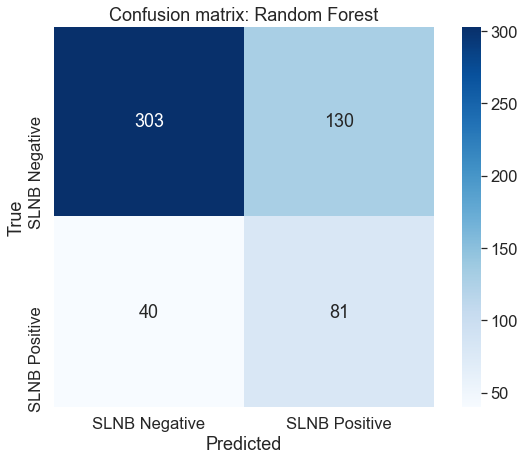

In [269]:
cm = confusion_matrix(y_test_sel, y_pred_sel)
df_cm = pd.DataFrame(cm, index = [i for i in ["SLNB Negative","SLNB Positive"]],
                  columns = [i for i in ["SLNB Negative","SLNB Positive"]])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True, cmap='Blues',square=True, fmt='d').set_title('Confusion matrix: Random Forest')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig(BASE_DIR+'../image/confusion_matrix.pdf')

In [390]:
303/(303+130)

0.6997690531177829

In [270]:
# pickling model
with open(BASE_DIR+'../model/balanced_rf_augmented_allknnimputed_binned.pkl', 'wb') as f:
    pkl.dump(rf, f)

## Logistic regression (no normalization+transformation of features)

In [283]:
# ridge
log_clf_sel = LogisticRegression(solver='saga',
                                 max_iter=10000, 
                                 class_weight='balanced'
                                )
log_clf_sel.fit(X_train_sel,y_train_sel.ravel())
y_prob_sel = np.asarray(log_clf_sel.predict_proba(X_test_sel))
y_pred_sel = np.asarray(log_clf_sel.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print(confusion_matrix(y_test_sel, y_pred_sel))
print("test accuracy: %s" % log_clf_sel.score(X_test_sel, y_test_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

# LASSO 
log_clf_sel = LogisticRegression(solver='saga',
                                 penalty='l1',
                                 max_iter=10000, 
                                 class_weight='balanced'
                                )
log_clf_sel.fit(X_train_sel,y_train_sel.ravel())
y_prob_sel = np.asarray(log_clf_sel.predict_proba(X_test_sel))
y_pred_sel = np.asarray(log_clf_sel.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print(confusion_matrix(y_test_sel, y_pred_sel))
print("test accuracy: %s" % log_clf_sel.score(X_test_sel, y_test_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

# ElasticNet 
log_clf_sel = LogisticRegression(solver='saga',
                                 penalty='elasticnet',
                                 max_iter=10000, 
                                 class_weight='balanced',
                                 l1_ratio=0.7
                                )
log_clf_sel.fit(X_train_sel,y_train_sel.ravel())
y_prob_sel = np.asarray(log_clf_sel.predict_proba(X_test_sel))
y_pred_sel = np.asarray(log_clf_sel.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print(confusion_matrix(y_test_sel, y_pred_sel))
print("test accuracy: %s" % log_clf_sel.score(X_test_sel, y_test_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

[[301 132]
 [ 49  72]]
test accuracy: 0.6732851985559567
test NPV: 0.86
test Precision: 0.35294117647058826
test Recall: 0.5950413223140496
test AUC: 0.6994541255511233
test F1: 0.4430769230769231
test AUPR: 0.3986720155089277
[[301 132]
 [ 49  72]]
test accuracy: 0.6732851985559567
test NPV: 0.86
test Precision: 0.35294117647058826
test Recall: 0.5950413223140496
test AUC: 0.6999694615692936
test F1: 0.4430769230769231
test AUPR: 0.40019310186262436
[[301 132]
 [ 49  72]]
test accuracy: 0.6732851985559567
test NPV: 0.86
test Precision: 0.35294117647058826
test Recall: 0.5950413223140496
test AUC: 0.6997213368198043
test F1: 0.4430769230769231
test AUPR: 0.3999845141257322


## Logistic regression (log transform age, tumor_size and depth) - worse

In [284]:
# read in data
mcc_ncdb = pd.read_pickle(BASE_DIR + '../data/Merkel_NCDB_augmented_clean.pkl')
# subset of features only
mcc_ncdb_sel = mcc_ncdb[['AGE','SEX','PRIMARY_SITE',
                        'TUMOR_SIZE', 'DEPTH', 
                        'LYMPH_VASCULAR_INVASION', 
                        'TUMOR_INFILTRATING_LYMPHOCYTES',
                        'IMMUNE_SUPPRESSION', 
                        'GROWTH_PATTERN',
                        'TUMOR_BASE_TRANSECTION',
                        'SLNB'
                       ]]


In [285]:
mcc_ncdb_sel.head()

,AGE,SEX,PRIMARY_SITE,TUMOR_SIZE,DEPTH,LYMPH_VASCULAR_INVASION,TUMOR_INFILTRATING_LYMPHOCYTES,IMMUNE_SUPPRESSION,GROWTH_PATTERN,TUMOR_BASE_TRANSECTION,SLNB
8,71,1,C444,10,999.0,0,999,999,999,999,0.0
12,87,1,C447,999,999.0,9,999,999,999,999,1.0
14,43,1,C443,2,10.0,9,0,0,999,20,0.0
19,59,2,C447,25,50.0,0,999,999,999,999,0.0
21,75,2,C446,30,999.0,9,999,999,999,999,1.0


In [286]:
mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'].value_counts()

999.0    7217
10.0     1159
20.0      988
0.0       526
Name: TUMOR_BASE_TRANSECTION, dtype: int64

In [287]:
# binning the categories
mcc_ncdb_sel['SEX'] = mcc_ncdb_sel['SEX'].replace([1, 2],
#                                                 ['Male', 'Female']
                                                  [0,1]
                                               )
mcc_ncdb_sel['PRIMARY_SITE'] = mcc_ncdb_sel['PRIMARY_SITE'].replace(['C440','C441','C442','C443',
                                                                     'C444','C445','C446','C447',
                                                                     'C448','C449'],
#                                                                     ['Head_and_Neck',
#                                                                      'Head_and_Neck',
#                                                                      'Head_and_Neck',
#                                                                      'Other',
#                                                                      'Head_and_Neck',
#                                                                      'Trunk',
#                                                                      'Extremity',
#                                                                      'Extremity',
#                                                                      'Other',
#                                                                      'Other']
                                                                    [0,0,0,3,0,1,2,2,3,3]
                                                                   )
mcc_ncdb_sel['LYMPH_VASCULAR_INVASION'] = mcc_ncdb_sel['LYMPH_VASCULAR_INVASION'].replace([0, 1, 8, 9],
#                                                                                           ['No',
#                                                                                            'Yes',
#                                                                                            np.nan,
#                                                                                            np.nan
#                                                                                           ]
                                                                                         [0,1,np.nan,np.nan]
                                                                                         )
mcc_ncdb_sel['TUMOR_INFILTRATING_LYMPHOCYTES'] = mcc_ncdb_sel['TUMOR_INFILTRATING_LYMPHOCYTES'].replace(
                                                                                          [0, 10, 20, 30, 999],
#                                                                                           ['Negative',
#                                                                                            'Weak',
#                                                                                            'Strong',
#                                                                                            'Present',
#                                                                                            np.nan
#                                                                                           ]
                                                                                        [0,1,2,3,np.nan]
                                                                                        )
mcc_ncdb_sel['IMMUNE_SUPPRESSION'] = mcc_ncdb_sel['IMMUNE_SUPPRESSION'].replace(
                                                                              [0, 10, 20, 30, 40,
                                                                               50, 60, 70, 999],
#                                                                               ['Negative',
#                                                                                'Positive',
#                                                                                'Positive',
#                                                                                'Positive',
#                                                                                'Positive',
#                                                                                'Positive',
#                                                                                'Positive',
#                                                                                'Positive',
#                                                                                np.nan
#                                                                               ]
                                                                                [0,1,1,1,1,1,1,1,np.nan]
                                                                            )
mcc_ncdb_sel['GROWTH_PATTERN'] = mcc_ncdb_sel['GROWTH_PATTERN'].replace([10, 20, 999],
#                                                                           ['Circumscribed_nodular',
#                                                                            'Diffusely_infiltrative',
#                                                                            np.nan]
                                                                        [0,1,np.nan]
                                                                        )

mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'] = mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'].replace([0, 10, 20, 999],
#                                                                                           ['Not_found',
#                                                                                            'Transected',
#                                                                                            'Not_transected',
#                                                                                            np.nan
#                                                                                           ]
                                                                                        [0,1,2,np.nan]
                                                                                       )

mcc_ncdb_sel['DEPTH'] = mcc_ncdb_sel['DEPTH'].replace([999],np.nan)
mcc_ncdb_sel['TUMOR_SIZE'] = mcc_ncdb_sel['TUMOR_SIZE'].replace([999],np.nan)

/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [288]:
# store a copy
mcc_ncdb_sel_cp = deepcopy(mcc_ncdb_sel)

## Count how many rows have missing value in all except AGE, SEX, PRIMARY_SITE, SLNB (indicating that they are not useful at all)

In [289]:
# mcc_ncdb_sel_count = mcc_ncdb_sel.drop(['AGE','SEX','PRIMARY_SITE','SLNB'], axis=1)
# mcc_ncdb_sel.drop(mcc_ncdb_sel_count.index[mcc_ncdb_sel_count.isnull().all(1)], axis=0)
# mcc_ncdb_sel.dropna(thresh=7)
print(mcc_ncdb_sel.dropna(thresh=6).SLNB.value_counts()) # make threshold = 6 i.e. at max 5 NaN
mcc_ncdb_sel.dropna(thresh=6, inplace=True)

0.0    4394
1.0    1146
Name: SLNB, dtype: int64


/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## Imputing all using kNN

In [290]:
mcc_ncdb_sel.head()

,AGE,SEX,PRIMARY_SITE,TUMOR_SIZE,DEPTH,LYMPH_VASCULAR_INVASION,TUMOR_INFILTRATING_LYMPHOCYTES,IMMUNE_SUPPRESSION,GROWTH_PATTERN,TUMOR_BASE_TRANSECTION,SLNB
8,71,0,0,10.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0
14,43,0,3,2.0,10.0,NaN,0.0,0.0,NaN,2.0,0.0
19,59,1,2,25.0,50.0,0.0,NaN,NaN,NaN,NaN,0.0
23,82,1,3,14.0,NaN,0.0,NaN,0.0,0.0,2.0,0.0
31,90,0,2,15.0,62.0,0.0,NaN,NaN,NaN,2.0,0.0


In [379]:
X_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns != 'SLNB'])
y_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns == 'SLNB'])
# # impute by KNN
# imputer = KNNImputer()
# X_sel = imputer.fit_transform(X_sel).round()

In [380]:
X_sel

array([[71.,  0.,  0., ..., nan, nan, nan],
       [43.,  0.,  3., ...,  0., nan,  2.],
       [59.,  1.,  2., ..., nan, nan, nan],
       ...,
       [32.,  0.,  0., ..., nan, nan, nan],
       [35.,  0.,  3., ...,  0., nan,  1.],
       [37.,  0.,  0., ..., nan,  0.,  1.]])

In [381]:
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import FunctionTransformer
# logTransformer = FunctionTransformer(np.log1p, validate=True)

# ct = ColumnTransformer(
#     [('oh_enc', OneHotEncoder(sparse=False), [1,2,5,6,7,8,9]),
#     ('log_transform', logTransformer, [0,3,4])],  # the column numbers I want to apply this to
#     remainder='passthrough'  # This leaves the rest of my columns in place
# )
# X_sel = ct.fit_transform(X_sel)

In [382]:
from sklearn.base import BaseEstimator,TransformerMixin

# class LogTransformer(BaseEstimator,TransformerMixin):
#     def __init__(self, constant=1, base='e'):
#         if base == 'e' or base == np.e:
#             self.log = np.log
#         elif base == '10' or base == 10:
#             self.log = np.log10
#         else:
#             base_log = np.log(base)
#             self.log = lambda x: np.log(x)/base_log
#         self.constant = constant
        
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X):
#         return self.log(X+self.constant)
    
class RoundTransformer(BaseEstimator,TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.round()
 

In [383]:
### combined pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler

numeric_columns = [0,3,4]
cat_columns = [1,2,5,6,7,8,9]

logTransformer = FunctionTransformer(np.log1p, validate=True)
numeric_pipeline = make_pipeline(logTransformer, MinMaxScaler())
cat_pipeline     = make_pipeline(OneHotEncoder(sparse=False))

ct = [
        ('num', numeric_pipeline, numeric_columns),
        ('cat', cat_pipeline, cat_columns)
     ]

preprocessor = Pipeline(steps=[
        ('imputer', KNNImputer()),
        ('rounder', RoundTransformer()),
        ('col_transformers',ColumnTransformer(ct, remainder='passthrough'))
    ])

X_sel = preprocessor.fit_transform(X_sel)

In [384]:
# split data
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, y_sel, 
                                                                test_size = 0.1, 
                                                                random_state = 123) # set seed to ensure reproducibility

In [385]:
# # save imputer
# with open(BASE_DIR+'../model/knn_imputer_augmented.pkl', 'wb') as f:
#     pkl.dump(imputer, f)

In [386]:
# mcc_ncdb_sel = pd.DataFrame(np.concatenate([X_sel[:,:3],y_sel,X_sel[:,3:]], axis=1), columns=mcc_ncdb_sel.columns)
# mcc_ncdb_sel_notencoded = mcc_ncdb_sel_cp
# mcc_ncdb_sel_notencoded['DEPTH'] = mcc_ncdb_sel['DEPTH']
# mcc_ncdb_sel_notencoded['TUMOR_SIZE'] = mcc_ncdb_sel['TUMOR_SIZE']

In [387]:
# # save cleaned data
# mcc_ncdb_sel.to_csv(BASE_DIR+"../data/Merkel_NCDB_augmented_clean_selectedVars_encoded_imputed.csv")
# mcc_ncdb_sel.to_pickle(BASE_DIR+"../data/Merkel_NCDB_augmented_clean_selectedVars_encoded_imputed.pkl")
# mcc_ncdb_sel_notencoded.to_csv(BASE_DIR+"../data/Merkel_NCDB_augmented_clean_selectedVars_imputed.csv")
# mcc_ncdb_sel_notencoded.to_pickle(BASE_DIR+"../data/Merkel_NCDB_augmented_clean_selectedVars_imputed.pkl")

In [388]:
X_train_sel.shape

(4986, 22)

In [389]:
# ridge
log_clf_sel = LogisticRegression(solver='saga',
                                 max_iter=10000, 
                                 class_weight='balanced'
                                )
log_clf_sel.fit(X_train_sel,y_train_sel.ravel())
y_prob_sel = np.asarray(log_clf_sel.predict_proba(X_test_sel))
y_pred_sel = np.asarray(log_clf_sel.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print(confusion_matrix(y_test_sel, y_pred_sel))
print("test accuracy: %s" % log_clf_sel.score(X_test_sel, y_test_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

# LASSO 
log_clf_sel = LogisticRegression(solver='saga',
                                 penalty='l1',
                                 max_iter=10000, 
                                 class_weight='balanced'
                                )
log_clf_sel.fit(X_train_sel,y_train_sel.ravel())
y_prob_sel = np.asarray(log_clf_sel.predict_proba(X_test_sel))
y_pred_sel = np.asarray(log_clf_sel.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print(confusion_matrix(y_test_sel, y_pred_sel))
print("test accuracy: %s" % log_clf_sel.score(X_test_sel, y_test_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

# ElasticNet 
log_clf_sel = LogisticRegression(solver='saga',
                                 penalty='elasticnet',
                                 max_iter=10000, 
                                 class_weight='balanced',
                                 l1_ratio=0.7
                                )
log_clf_sel.fit(X_train_sel,y_train_sel.ravel())
y_prob_sel = np.asarray(log_clf_sel.predict_proba(X_test_sel))
y_pred_sel = np.asarray(log_clf_sel.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print(confusion_matrix(y_test_sel, y_pred_sel))
print("test accuracy: %s" % log_clf_sel.score(X_test_sel, y_test_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

[[297 136]
 [ 52  69]]
test accuracy: 0.6606498194945848
test NPV: 0.8510028653295129
test Precision: 0.33658536585365856
test Recall: 0.5702479338842975
test AUC: 0.6801576546485217
test F1: 0.4233128834355829
test AUPR: 0.3833533443977517
[[297 136]
 [ 53  68]]
test accuracy: 0.6588447653429603
test NPV: 0.8485714285714285
test Precision: 0.3333333333333333
test Recall: 0.5619834710743802
test AUC: 0.681398278395969
test F1: 0.41846153846153844
test AUPR: 0.38460311417296983
[[297 136]
 [ 52  69]]
test accuracy: 0.6606498194945848
test NPV: 0.8510028653295129
test Precision: 0.33658536585365856
test Recall: 0.5702479338842975
test AUC: 0.681131067127288
test F1: 0.4233128834355829
test AUPR: 0.3839891001472816


## Logistic regression (feature engineering to create 3D tumor)

In [462]:
# read in data
mcc_ncdb = pd.read_pickle(BASE_DIR + '../data/Merkel_NCDB_augmented_clean.pkl')
# subset of features only
mcc_ncdb_sel = mcc_ncdb[['AGE','SEX','PRIMARY_SITE',
                        'TUMOR_SIZE', 'DEPTH', 
                        'LYMPH_VASCULAR_INVASION', 
                        'TUMOR_INFILTRATING_LYMPHOCYTES',
                        'IMMUNE_SUPPRESSION', 
                        'GROWTH_PATTERN',
                        'TUMOR_BASE_TRANSECTION',
                        'SLNB'
                       ]]


In [463]:
mcc_ncdb_sel.head()

,AGE,SEX,PRIMARY_SITE,TUMOR_SIZE,DEPTH,LYMPH_VASCULAR_INVASION,TUMOR_INFILTRATING_LYMPHOCYTES,IMMUNE_SUPPRESSION,GROWTH_PATTERN,TUMOR_BASE_TRANSECTION,SLNB
8,71,1,C444,10,999.0,0,999,999,999,999,0.0
12,87,1,C447,999,999.0,9,999,999,999,999,1.0
14,43,1,C443,2,10.0,9,0,0,999,20,0.0
19,59,2,C447,25,50.0,0,999,999,999,999,0.0
21,75,2,C446,30,999.0,9,999,999,999,999,1.0


In [464]:
mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'].value_counts()

999.0    7217
10.0     1159
20.0      988
0.0       526
Name: TUMOR_BASE_TRANSECTION, dtype: int64

In [465]:
# binning the categories
mcc_ncdb_sel['SEX'] = mcc_ncdb_sel['SEX'].replace([1, 2],
#                                                 ['Male', 'Female']
                                                  [0,1]
                                               )
mcc_ncdb_sel['PRIMARY_SITE'] = mcc_ncdb_sel['PRIMARY_SITE'].replace(['C440','C441','C442','C443',
                                                                     'C444','C445','C446','C447',
                                                                     'C448','C449'],
#                                                                     ['Head_and_Neck',
#                                                                      'Head_and_Neck',
#                                                                      'Head_and_Neck',
#                                                                      'Other',
#                                                                      'Head_and_Neck',
#                                                                      'Trunk',
#                                                                      'Extremity',
#                                                                      'Extremity',
#                                                                      'Other',
#                                                                      'Other']
                                                                    [0,0,0,3,0,1,2,2,3,3]
                                                                   )
mcc_ncdb_sel['LYMPH_VASCULAR_INVASION'] = mcc_ncdb_sel['LYMPH_VASCULAR_INVASION'].replace([0, 1, 8, 9],
#                                                                                           ['No',
#                                                                                            'Yes',
#                                                                                            np.nan,
#                                                                                            np.nan
#                                                                                           ]
                                                                                         [0,1,np.nan,np.nan]
                                                                                         )
mcc_ncdb_sel['TUMOR_INFILTRATING_LYMPHOCYTES'] = mcc_ncdb_sel['TUMOR_INFILTRATING_LYMPHOCYTES'].replace(
                                                                                          [0, 10, 20, 30, 999],
#                                                                                           ['Negative',
#                                                                                            'Weak',
#                                                                                            'Strong',
#                                                                                            'Present',
#                                                                                            np.nan
#                                                                                           ]
                                                                                        [0,1,2,3,np.nan]
                                                                                        )
mcc_ncdb_sel['IMMUNE_SUPPRESSION'] = mcc_ncdb_sel['IMMUNE_SUPPRESSION'].replace(
                                                                              [0, 10, 20, 30, 40,
                                                                               50, 60, 70, 999],
#                                                                               ['Negative',
#                                                                                'Positive',
#                                                                                'Positive',
#                                                                                'Positive',
#                                                                                'Positive',
#                                                                                'Positive',
#                                                                                'Positive',
#                                                                                'Positive',
#                                                                                np.nan
#                                                                               ]
                                                                                [0,1,1,1,1,1,1,1,np.nan]
                                                                            )
mcc_ncdb_sel['GROWTH_PATTERN'] = mcc_ncdb_sel['GROWTH_PATTERN'].replace([10, 20, 999],
#                                                                           ['Circumscribed_nodular',
#                                                                            'Diffusely_infiltrative',
#                                                                            np.nan]
                                                                        [0,1,np.nan]
                                                                        )

mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'] = mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'].replace([0, 10, 20, 999],
#                                                                                           ['Not_found',
#                                                                                            'Transected',
#                                                                                            'Not_transected',
#                                                                                            np.nan
#                                                                                           ]
                                                                                        [0,1,2,np.nan]
                                                                                       )

mcc_ncdb_sel['DEPTH'] = mcc_ncdb_sel['DEPTH'].replace([999],np.nan)
mcc_ncdb_sel['TUMOR_SIZE'] = mcc_ncdb_sel['TUMOR_SIZE'].replace([999],np.nan)

/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

## create 3D feature, depth * tumor_size

In [466]:
mcc_ncdb_sel['VOLUME'] = 4./3.*np.pi*((mcc_ncdb_sel['TUMOR_SIZE']/2.)**2)*mcc_ncdb_sel['DEPTH']

/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Count how many rows have missing value in all except AGE, SEX, PRIMARY_SITE, SLNB (indicating that they are not useful at all)

In [467]:
# mcc_ncdb_sel_count = mcc_ncdb_sel.drop(['AGE','SEX','PRIMARY_SITE','SLNB'], axis=1)
# mcc_ncdb_sel.drop(mcc_ncdb_sel_count.index[mcc_ncdb_sel_count.isnull().all(1)], axis=0)
# mcc_ncdb_sel.dropna(thresh=7)
print(mcc_ncdb_sel.dropna(thresh=6).SLNB.value_counts()) # make threshold = 6 i.e. at max 5 NaN
mcc_ncdb_sel.dropna(thresh=6, inplace=True)

0.0    4394
1.0    1146
Name: SLNB, dtype: int64


/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## Imputing all using kNN

In [468]:
mcc_ncdb_sel.head()

,AGE,SEX,PRIMARY_SITE,TUMOR_SIZE,DEPTH,LYMPH_VASCULAR_INVASION,TUMOR_INFILTRATING_LYMPHOCYTES,IMMUNE_SUPPRESSION,GROWTH_PATTERN,TUMOR_BASE_TRANSECTION,SLNB,VOLUME
8,71,0,0,10.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN
14,43,0,3,2.0,10.0,NaN,0.0,0.0,NaN,2.0,0.0,41.887902
19,59,1,2,25.0,50.0,0.0,NaN,NaN,NaN,NaN,0.0,32724.923475
23,82,1,3,14.0,NaN,0.0,NaN,0.0,0.0,2.0,0.0,NaN
31,90,0,2,15.0,62.0,0.0,NaN,NaN,NaN,2.0,0.0,14608.405839


In [525]:
X_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns != 'SLNB'])
y_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns == 'SLNB'])
# # impute by KNN
# imputer = KNNImputer()
# X_sel = imputer.fit_transform(X_sel).round()

In [526]:
X_sel

array([[7.10000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
                   nan,            nan,            nan],
       [4.30000000e+01, 0.00000000e+00, 3.00000000e+00, ...,
                   nan, 2.00000000e+00, 4.18879020e+01],
       [5.90000000e+01, 1.00000000e+00, 2.00000000e+00, ...,
                   nan,            nan, 3.27249235e+04],
       ...,
       [3.20000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
                   nan,            nan,            nan],
       [3.50000000e+01, 0.00000000e+00, 3.00000000e+00, ...,
                   nan, 1.00000000e+00,            nan],
       [3.70000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 1.40910902e+04]])

In [527]:
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import FunctionTransformer
# logTransformer = FunctionTransformer(np.log1p, validate=True)

# ct = ColumnTransformer(
#     [('oh_enc', OneHotEncoder(sparse=False), [1,2,5,6,7,8,9]),
#     ('log_transform', logTransformer, [0,3,4])],  # the column numbers I want to apply this to
#     remainder='passthrough'  # This leaves the rest of my columns in place
# )
# X_sel = ct.fit_transform(X_sel)

In [528]:
from sklearn.base import BaseEstimator,TransformerMixin

# class LogTransformer(BaseEstimator,TransformerMixin):
#     def __init__(self, constant=1, base='e'):
#         if base == 'e' or base == np.e:
#             self.log = np.log
#         elif base == '10' or base == 10:
#             self.log = np.log10
#         else:
#             base_log = np.log(base)
#             self.log = lambda x: np.log(x)/base_log
#         self.constant = constant
        
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X):
#         return self.log(X+self.constant)
    
class RoundTransformer(BaseEstimator,TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.round()
 

In [529]:
### combined pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler

numeric_columns = [0,3,4]
cat_columns = [1,2,5,6,7,8,9]
volumn = [10]

logTransformer = FunctionTransformer(np.log1p, validate=True)
# numeric_pipeline = make_pipeline(logTransformer, 
# #                                  MinMaxScaler()
#                                 )
cat_pipeline     = make_pipeline(OneHotEncoder(sparse=False))
vol_pipeline = make_pipeline(logTransformer, 
#                              StandardScaler()
                            )

ct = [
        ('num', numeric_pipeline, numeric_columns),
        ('cat', cat_pipeline, cat_columns),
        ('vol', vol_pipeline, volumn)
     ]

preprocessor = Pipeline(steps=[
        ('imputer', KNNImputer()),
        ('rounder', RoundTransformer()),
        ('col_transformers',ColumnTransformer(ct, remainder='passthrough'))
    ])

X_sel = preprocessor.fit_transform(X_sel)

In [530]:
# split data
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, y_sel, 
                                                                test_size = 0.1, 
                                                                random_state = 123) # set seed to ensure reproducibility

In [531]:
# # save imputer
# with open(BASE_DIR+'../model/knn_imputer_augmented.pkl', 'wb') as f:
#     pkl.dump(imputer, f)

In [532]:
# mcc_ncdb_sel = pd.DataFrame(np.concatenate([X_sel[:,:3],y_sel,X_sel[:,3:]], axis=1), columns=mcc_ncdb_sel.columns)
# mcc_ncdb_sel_notencoded = mcc_ncdb_sel_cp
# mcc_ncdb_sel_notencoded['DEPTH'] = mcc_ncdb_sel['DEPTH']
# mcc_ncdb_sel_notencoded['TUMOR_SIZE'] = mcc_ncdb_sel['TUMOR_SIZE']

In [533]:
# # save cleaned data
# mcc_ncdb_sel.to_csv(BASE_DIR+"../data/Merkel_NCDB_augmented_clean_selectedVars_encoded_imputed.csv")
# mcc_ncdb_sel.to_pickle(BASE_DIR+"../data/Merkel_NCDB_augmented_clean_selectedVars_encoded_imputed.pkl")
# mcc_ncdb_sel_notencoded.to_csv(BASE_DIR+"../data/Merkel_NCDB_augmented_clean_selectedVars_imputed.csv")
# mcc_ncdb_sel_notencoded.to_pickle(BASE_DIR+"../data/Merkel_NCDB_augmented_clean_selectedVars_imputed.pkl")

In [534]:
X_sel

array([[ 4.27666612,  2.39789527,  3.80666249, ...,  1.        ,
         0.        ,  9.96095425],
       [ 3.78418963,  1.09861229,  2.39789527, ...,  0.        ,
         1.        ,  3.76120012],
       [ 4.09434456,  3.25809654,  3.93182563, ...,  0.        ,
         0.        , 10.39592515],
       ...,
       [ 3.49650756,  2.39789527,  4.04305127, ...,  1.        ,
         0.        ,  8.97347815],
       [ 3.58351894,  1.79175947,  3.04452244, ...,  1.        ,
         0.        ,  7.01301579],
       [ 3.63758616,  3.40119738,  2.83321334, ...,  1.        ,
         0.        ,  9.55336254]])

In [535]:
X_sel[0]

array([4.27666612, 2.39789527, 3.80666249, 1.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 1.        , 0.        ,
       1.        , 0.        , 9.96095425])

In [536]:
X_train_sel.shape

(4986, 23)

In [537]:
# ridge
log_clf_sel = LogisticRegression(solver='saga',
                                 max_iter=10000, 
                                 class_weight='balanced'
                                )
log_clf_sel.fit(X_train_sel,y_train_sel.ravel())
y_prob_sel = np.asarray(log_clf_sel.predict_proba(X_test_sel))
y_pred_sel = np.asarray(log_clf_sel.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print(confusion_matrix(y_test_sel, y_pred_sel))
print("test accuracy: %s" % log_clf_sel.score(X_test_sel, y_test_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

# LASSO 
log_clf_sel = LogisticRegression(solver='saga',
                                 penalty='l1',
                                 max_iter=10000, 
                                 class_weight='balanced'
                                )
log_clf_sel.fit(X_train_sel,y_train_sel.ravel())
y_prob_sel = np.asarray(log_clf_sel.predict_proba(X_test_sel))
y_pred_sel = np.asarray(log_clf_sel.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print(confusion_matrix(y_test_sel, y_pred_sel))
print("test accuracy: %s" % log_clf_sel.score(X_test_sel, y_test_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

# ElasticNet 
log_clf_sel = LogisticRegression(solver='saga',
                                 penalty='elasticnet',
                                 max_iter=10000, 
                                 class_weight='balanced',
                                 l1_ratio=0.7
                                )
log_clf_sel.fit(X_train_sel,y_train_sel.ravel())
y_prob_sel = np.asarray(log_clf_sel.predict_proba(X_test_sel))
y_pred_sel = np.asarray(log_clf_sel.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print(confusion_matrix(y_test_sel, y_pred_sel))
print("test accuracy: %s" % log_clf_sel.score(X_test_sel, y_test_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

[[302 131]
 [ 54  67]]
test accuracy: 0.6660649819494585
test NPV: 0.848314606741573
test Precision: 0.3383838383838384
test Recall: 0.5537190082644629
test AUC: 0.6798140973030747
test F1: 0.420062695924765
test AUPR: 0.37267904764821447
[[304 129]
 [ 53  68]]
test accuracy: 0.6714801444043321
test NPV: 0.8515406162464986
test Precision: 0.34517766497461927
test Recall: 0.5619834710743802
test AUC: 0.6806348176283091
test F1: 0.42767295597484273
test AUPR: 0.3751696273972832
[[304 129]
 [ 53  68]]
test accuracy: 0.6714801444043321
test NPV: 0.8515406162464986
test Precision: 0.34517766497461927
test Recall: 0.5619834710743802
test AUC: 0.6804248659172025
test F1: 0.42767295597484273
test AUPR: 0.37472304652636534


## Balanced RF (feature engineering, k-NN impute, OH for categorical, log transform volume)

In [538]:
# read in data
mcc_ncdb = pd.read_pickle(BASE_DIR + '../data/Merkel_NCDB_augmented_clean.pkl')
# subset of features only
mcc_ncdb_sel = mcc_ncdb[['AGE','SEX','PRIMARY_SITE',
                        'TUMOR_SIZE', 'DEPTH', 
                        'LYMPH_VASCULAR_INVASION', 
                        'TUMOR_INFILTRATING_LYMPHOCYTES',
                        'IMMUNE_SUPPRESSION', 
                        'GROWTH_PATTERN',
                        'TUMOR_BASE_TRANSECTION',
                        'SLNB'
                       ]]


In [539]:
mcc_ncdb_sel.head()

,AGE,SEX,PRIMARY_SITE,TUMOR_SIZE,DEPTH,LYMPH_VASCULAR_INVASION,TUMOR_INFILTRATING_LYMPHOCYTES,IMMUNE_SUPPRESSION,GROWTH_PATTERN,TUMOR_BASE_TRANSECTION,SLNB
8,71,1,C444,10,999.0,0,999,999,999,999,0.0
12,87,1,C447,999,999.0,9,999,999,999,999,1.0
14,43,1,C443,2,10.0,9,0,0,999,20,0.0
19,59,2,C447,25,50.0,0,999,999,999,999,0.0
21,75,2,C446,30,999.0,9,999,999,999,999,1.0


In [540]:
mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'].value_counts()

999.0    7217
10.0     1159
20.0      988
0.0       526
Name: TUMOR_BASE_TRANSECTION, dtype: int64

In [541]:
# binning the categories
mcc_ncdb_sel['SEX'] = mcc_ncdb_sel['SEX'].replace([1, 2],
#                                                 ['Male', 'Female']
                                                  [0,1]
                                               )
mcc_ncdb_sel['PRIMARY_SITE'] = mcc_ncdb_sel['PRIMARY_SITE'].replace(['C440','C441','C442','C443',
                                                                     'C444','C445','C446','C447',
                                                                     'C448','C449'],
#                                                                     ['Head_and_Neck',
#                                                                      'Head_and_Neck',
#                                                                      'Head_and_Neck',
#                                                                      'Other',
#                                                                      'Head_and_Neck',
#                                                                      'Trunk',
#                                                                      'Extremity',
#                                                                      'Extremity',
#                                                                      'Other',
#                                                                      'Other']
                                                                    [0,0,0,3,0,1,2,2,3,3]
                                                                   )
mcc_ncdb_sel['LYMPH_VASCULAR_INVASION'] = mcc_ncdb_sel['LYMPH_VASCULAR_INVASION'].replace([0, 1, 8, 9],
#                                                                                           ['No',
#                                                                                            'Yes',
#                                                                                            np.nan,
#                                                                                            np.nan
#                                                                                           ]
                                                                                         [0,1,np.nan,np.nan]
                                                                                         )
mcc_ncdb_sel['TUMOR_INFILTRATING_LYMPHOCYTES'] = mcc_ncdb_sel['TUMOR_INFILTRATING_LYMPHOCYTES'].replace(
                                                                                          [0, 10, 20, 30, 999],
#                                                                                           ['Negative',
#                                                                                            'Weak',
#                                                                                            'Strong',
#                                                                                            'Present',
#                                                                                            np.nan
#                                                                                           ]
                                                                                        [0,1,2,3,np.nan]
                                                                                        )
mcc_ncdb_sel['IMMUNE_SUPPRESSION'] = mcc_ncdb_sel['IMMUNE_SUPPRESSION'].replace(
                                                                              [0, 10, 20, 30, 40,
                                                                               50, 60, 70, 999],
#                                                                               ['Negative',
#                                                                                'Positive',
#                                                                                'Positive',
#                                                                                'Positive',
#                                                                                'Positive',
#                                                                                'Positive',
#                                                                                'Positive',
#                                                                                'Positive',
#                                                                                np.nan
#                                                                               ]
                                                                                [0,1,1,1,1,1,1,1,np.nan]
                                                                            )
mcc_ncdb_sel['GROWTH_PATTERN'] = mcc_ncdb_sel['GROWTH_PATTERN'].replace([10, 20, 999],
#                                                                           ['Circumscribed_nodular',
#                                                                            'Diffusely_infiltrative',
#                                                                            np.nan]
                                                                        [0,1,np.nan]
                                                                        )

mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'] = mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'].replace([0, 10, 20, 999],
#                                                                                           ['Not_found',
#                                                                                            'Transected',
#                                                                                            'Not_transected',
#                                                                                            np.nan
#                                                                                           ]
                                                                                        [0,1,2,np.nan]
                                                                                       )

mcc_ncdb_sel['DEPTH'] = mcc_ncdb_sel['DEPTH'].replace([999],np.nan)
mcc_ncdb_sel['TUMOR_SIZE'] = mcc_ncdb_sel['TUMOR_SIZE'].replace([999],np.nan)

/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

## create 3D feature, depth * tumor_size

In [542]:
mcc_ncdb_sel['VOLUME'] = 4./3.*np.pi*((mcc_ncdb_sel['TUMOR_SIZE']/2.)**2)*mcc_ncdb_sel['DEPTH']

/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Count how many rows have missing value in all except AGE, SEX, PRIMARY_SITE, SLNB (indicating that they are not useful at all)

In [543]:
# mcc_ncdb_sel_count = mcc_ncdb_sel.drop(['AGE','SEX','PRIMARY_SITE','SLNB'], axis=1)
# mcc_ncdb_sel.drop(mcc_ncdb_sel_count.index[mcc_ncdb_sel_count.isnull().all(1)], axis=0)
# mcc_ncdb_sel.dropna(thresh=7)
print(mcc_ncdb_sel.dropna(thresh=6).SLNB.value_counts()) # make threshold = 6 i.e. at max 5 NaN
mcc_ncdb_sel.dropna(thresh=6, inplace=True)

0.0    4394
1.0    1146
Name: SLNB, dtype: int64


/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## Imputing all using kNN

In [544]:
mcc_ncdb_sel.head()

,AGE,SEX,PRIMARY_SITE,TUMOR_SIZE,DEPTH,LYMPH_VASCULAR_INVASION,TUMOR_INFILTRATING_LYMPHOCYTES,IMMUNE_SUPPRESSION,GROWTH_PATTERN,TUMOR_BASE_TRANSECTION,SLNB,VOLUME
8,71,0,0,10.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN
14,43,0,3,2.0,10.0,NaN,0.0,0.0,NaN,2.0,0.0,41.887902
19,59,1,2,25.0,50.0,0.0,NaN,NaN,NaN,NaN,0.0,32724.923475
23,82,1,3,14.0,NaN,0.0,NaN,0.0,0.0,2.0,0.0,NaN
31,90,0,2,15.0,62.0,0.0,NaN,NaN,NaN,2.0,0.0,14608.405839


In [609]:
X_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns != 'SLNB'])
y_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns == 'SLNB'])
# # impute by KNN
# imputer = KNNImputer()
# X_sel = imputer.fit_transform(X_sel).round()

In [610]:
X_sel

array([[7.10000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
                   nan,            nan,            nan],
       [4.30000000e+01, 0.00000000e+00, 3.00000000e+00, ...,
                   nan, 2.00000000e+00, 4.18879020e+01],
       [5.90000000e+01, 1.00000000e+00, 2.00000000e+00, ...,
                   nan,            nan, 3.27249235e+04],
       ...,
       [3.20000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
                   nan,            nan,            nan],
       [3.50000000e+01, 0.00000000e+00, 3.00000000e+00, ...,
                   nan, 1.00000000e+00,            nan],
       [3.70000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 1.40910902e+04]])

In [611]:
from sklearn.base import BaseEstimator,TransformerMixin

class RoundTransformer(BaseEstimator,TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.round()
 

In [612]:
### combined pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler

numeric_columns = [0,3,4]
cat_columns = [1,2,5,6,7,8,9]
volumn = [10]

logTransformer = FunctionTransformer(np.log1p, validate=True)
# numeric_pipeline = make_pipeline(logTransformer, 
#                                  MinMaxScaler()
#                                 )
cat_pipeline     = make_pipeline(OneHotEncoder(sparse=False))
vol_pipeline     = make_pipeline(
#                             logTransformer, 
                             StandardScaler()
                            )

ct = [
#         ('num', numeric_pipeline, numeric_columns),
        ('cat', cat_pipeline, cat_columns),
        ('vol', vol_pipeline, volumn)
     ]

preprocessor = Pipeline(steps=[
        ('imputer', KNNImputer()),
        ('rounder', RoundTransformer()),
        ('col_transformers',ColumnTransformer(ct, remainder='passthrough'))
    ])

X_sel = preprocessor.fit_transform(X_sel)

In [613]:
# split data
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, y_sel, 
                                                                test_size = 0.1, 
                                                                random_state = 123) # set seed to ensure reproducibility

In [614]:
X_train_sel.shape

(4986, 23)

In [615]:
X_train_sel[1]

array([  1.        ,   0.        ,   0.        ,   0.        ,
         1.        ,   0.        ,   1.        ,   0.        ,
         1.        ,   0.        ,   0.        ,   0.        ,
         1.        ,   0.        ,   1.        ,   0.        ,
         1.        ,   0.        ,   0.        ,  -0.32489899,
        54.        ,  20.        , 110.        ])

In [616]:
# train a random forest classifier
rf = BalancedRandomForestClassifier(
                            n_estimators=1000,
                            max_depth=50,
                            max_features = 7,
                            oob_score=True, 
                            random_state=123) # set seed to ensure reproducibility
rf.fit(X_train_sel,y_train_sel.ravel())
y_prob_sel = np.asarray(rf.predict_proba(X_test_sel))
y_pred_sel = np.asarray(rf.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % accuracy_score(y_test_sel, y_pred_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

test accuracy: 0.6137184115523465
test NPV: 0.8476190476190476
test Precision: 0.3054393305439331
test Recall: 0.6033057851239669
test AUC: 0.6668638940316455
test F1: 0.40555555555555556
test AUPR: 0.3781860555310049


In [617]:
# RandomForest + Bayesian optimization
opt_rf = BayesSearchCV(BalancedRandomForestClassifier(oob_score=True,
                                     random_state=123),
                       {
                        'n_estimators': (100,2000),
                        'max_depth': (1, 50),  
                        'criterion': ['gini','entropy'],
                        'max_features': (1,23),
                       }, 
                        n_iter = 30, verbose = 5, 
                       scoring=make_scorer(f1_score),
                       n_jobs=6)

# callback handler
def on_step(optim_result):
    score = opt_rf.best_score_
    print("best score: %s" % score)
#     with open("./rf_checkpoint.pkl", 'wb') as pickle_file:
#         pkl.dump(opt_rf, pickle_file)
    if score >= 0.5:
        print('Interrupting...')
        return True
    
opt_rf.fit(X_train_sel, y_train_sel.ravel(), callback=[on_step])

print("best parameter set: %s" % opt_rf.best_params_)
print("val. score: %s" % opt_rf.best_score_)
# print("test score: %s" % opt_rf.score(X_test, y_test))
y_prob_sel = np.asarray(opt_rf.predict_proba(X_test_sel))
y_pred_sel = np.asarray(opt_rf.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % accuracy_score(y_test_sel, y_pred_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   19.1s remaining:   28.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   19.5s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.36703212000337865
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   23.0s remaining:   34.4s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   25.4s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.3781945473206736
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   20.4s remaining:   30.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   20.6s finished


best score: 0.3781945473206736
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   17.0s remaining:   25.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   17.3s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.3781945473206736
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   12.3s remaining:   18.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   12.6s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.3781945473206736
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   22.9s remaining:   34.3s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   23.2s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.3781945473206736
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    1.3s remaining:    1.9s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.39270851722176914
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    8.8s remaining:   13.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    8.9s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.39270851722176914
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   19.3s remaining:   29.0s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   19.5s finished


best score: 0.39270851722176914
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   32.1s remaining:   48.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   32.4s finished


best score: 0.39270851722176914
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    1.0s finished


best score: 0.39270851722176914
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    5.3s remaining:    8.0s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    5.5s finished


best score: 0.39270851722176914
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.9s finished


best score: 0.39270851722176914
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   14.6s remaining:   21.9s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   14.7s finished


best score: 0.39270851722176914
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   18.0s remaining:   27.0s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   18.2s finished


best score: 0.39270851722176914
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    1.1s finished


best score: 0.39270851722176914
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   33.1s remaining:   49.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   33.4s finished


best score: 0.39270851722176914
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   12.0s remaining:   18.0s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   12.1s finished


best score: 0.39270851722176914
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   13.5s remaining:   20.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   13.7s finished


best score: 0.39270851722176914
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   14.4s remaining:   21.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   14.5s finished


best score: 0.39270851722176914
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   14.7s remaining:   22.0s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   14.8s finished


best score: 0.39270851722176914
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   33.6s remaining:   50.4s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   34.1s finished


best score: 0.39270851722176914
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   10.1s remaining:   15.1s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   10.2s finished


best score: 0.39270851722176914
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.2s finished


best score: 0.39270851722176914
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.7s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.5s finished


best score: 0.39270851722176914
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   17.8s remaining:   26.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   17.9s finished


best score: 0.39270851722176914
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   15.3s remaining:   23.0s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   15.6s finished


best score: 0.39270851722176914
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.8s finished


best score: 0.39270851722176914
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    1.9s remaining:    2.8s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    1.9s finished


best score: 0.39270851722176914
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    2.1s remaining:    3.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.2s finished


best score: 0.39270851722176914
best parameter set: OrderedDict([('criterion', 'gini'), ('max_depth', 4), ('max_features', 1), ('n_estimators', 186)])
val. score: 0.39270851722176914
test accuracy: 0.6498194945848376
test NPV: 0.8504398826979472
test Precision: 0.3286384976525822
test Recall: 0.5785123966942148
test AUC: 0.7005516004046342
test F1: 0.4191616766467066
test AUPR: 0.38798869019369336


## final balanced RF (k-NN impute, OH for categorical)

In [622]:
# read in data
mcc_ncdb = pd.read_pickle(BASE_DIR + '../data/Merkel_NCDB_augmented_clean.pkl')
# subset of features only
mcc_ncdb_sel = mcc_ncdb[['AGE','SEX','PRIMARY_SITE',
                        'TUMOR_SIZE', 'DEPTH', 
                        'LYMPH_VASCULAR_INVASION', 
                        'TUMOR_INFILTRATING_LYMPHOCYTES',
                        'IMMUNE_SUPPRESSION', 
                        'GROWTH_PATTERN',
                        'TUMOR_BASE_TRANSECTION',
                        'SLNB'
                       ]]


In [623]:
mcc_ncdb_sel.head()

,AGE,SEX,PRIMARY_SITE,TUMOR_SIZE,DEPTH,LYMPH_VASCULAR_INVASION,TUMOR_INFILTRATING_LYMPHOCYTES,IMMUNE_SUPPRESSION,GROWTH_PATTERN,TUMOR_BASE_TRANSECTION,SLNB
8,71,1,C444,10,999.0,0,999,999,999,999,0.0
12,87,1,C447,999,999.0,9,999,999,999,999,1.0
14,43,1,C443,2,10.0,9,0,0,999,20,0.0
19,59,2,C447,25,50.0,0,999,999,999,999,0.0
21,75,2,C446,30,999.0,9,999,999,999,999,1.0


In [624]:
mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'].value_counts()

999.0    7217
10.0     1159
20.0      988
0.0       526
Name: TUMOR_BASE_TRANSECTION, dtype: int64

In [625]:
# binning the categories
mcc_ncdb_sel.loc[:,'SEX'] = mcc_ncdb_sel['SEX'].replace([1, 2],
                                                  [0,1]
                                               )
mcc_ncdb_sel.loc[:,'PRIMARY_SITE'] = mcc_ncdb_sel['PRIMARY_SITE'].replace(['C440','C441','C442','C443',
                                                                     'C444','C445','C446','C447',
                                                                     'C448','C449'],
                                                                    [0,0,0,3,0,1,2,2,3,3]
                                                                   )
mcc_ncdb_sel.loc[:,'LYMPH_VASCULAR_INVASION'] = mcc_ncdb_sel['LYMPH_VASCULAR_INVASION'].replace([0, 1, 8, 9],
                                                                                         [0,1,np.nan,np.nan]
                                                                                         )
mcc_ncdb_sel.loc[:,'TUMOR_INFILTRATING_LYMPHOCYTES'] = mcc_ncdb_sel['TUMOR_INFILTRATING_LYMPHOCYTES'].replace(
                                                                                          [0, 10, 20, 30, 999],
                                                                                        [0,1,2,3,np.nan]
                                                                                        )
mcc_ncdb_sel.loc[:,'IMMUNE_SUPPRESSION'] = mcc_ncdb_sel['IMMUNE_SUPPRESSION'].replace(
                                                                              [0, 10, 20, 30, 40,
                                                                               50, 60, 70, 999],
                                                                                [0,1,1,1,1,1,1,1,np.nan]
                                                                            )
mcc_ncdb_sel.loc[:,'GROWTH_PATTERN'] = mcc_ncdb_sel['GROWTH_PATTERN'].replace([10, 20, 999],
                                                                        [0,1,np.nan]
                                                                        )

mcc_ncdb_sel.loc[:,'TUMOR_BASE_TRANSECTION'] = mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'].replace([0, 10, 20, 999],
                                                                                        [0,1,2,np.nan]
                                                                                       )

mcc_ncdb_sel.loc[:,'DEPTH'] = mcc_ncdb_sel['DEPTH'].replace([999],np.nan)
mcc_ncdb_sel.loc[:,'TUMOR_SIZE'] = mcc_ncdb_sel['TUMOR_SIZE'].replace([999],np.nan)

/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


## Count how many rows have missing value in all except AGE, SEX, PRIMARY_SITE, SLNB (indicating that they are not useful at all)

In [626]:
# mcc_ncdb_sel_count = mcc_ncdb_sel.drop(['AGE','SEX','PRIMARY_SITE','SLNB'], axis=1)
# mcc_ncdb_sel.drop(mcc_ncdb_sel_count.index[mcc_ncdb_sel_count.isnull().all(1)], axis=0)
# mcc_ncdb_sel.dropna(thresh=7)
print(mcc_ncdb_sel.dropna(thresh=6).SLNB.value_counts()) # make threshold = 6 i.e. at max 5 NaN
mcc_ncdb_sel.dropna(thresh=6, inplace=True)

0.0    4394
1.0    1146
Name: SLNB, dtype: int64


/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## Imputing all using kNN

In [627]:
mcc_ncdb_sel.head()

,AGE,SEX,PRIMARY_SITE,TUMOR_SIZE,DEPTH,LYMPH_VASCULAR_INVASION,TUMOR_INFILTRATING_LYMPHOCYTES,IMMUNE_SUPPRESSION,GROWTH_PATTERN,TUMOR_BASE_TRANSECTION,SLNB
8,71,0,0,10.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0
14,43,0,3,2.0,10.0,NaN,0.0,0.0,NaN,2.0,0.0
19,59,1,2,25.0,50.0,0.0,NaN,NaN,NaN,NaN,0.0
23,82,1,3,14.0,NaN,0.0,NaN,0.0,0.0,2.0,0.0
31,90,0,2,15.0,62.0,0.0,NaN,NaN,NaN,2.0,0.0


In [628]:
X_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns != 'SLNB'])
y_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns == 'SLNB'])
# # impute by KNN
# imputer = KNNImputer()
# X_sel = imputer.fit_transform(X_sel).round()

In [629]:
X_sel

array([[71.,  0.,  0., ..., nan, nan, nan],
       [43.,  0.,  3., ...,  0., nan,  2.],
       [59.,  1.,  2., ..., nan, nan, nan],
       ...,
       [32.,  0.,  0., ..., nan, nan, nan],
       [35.,  0.,  3., ...,  0., nan,  1.],
       [37.,  0.,  0., ..., nan,  0.,  1.]])

In [630]:
from sklearn.base import BaseEstimator,TransformerMixin

class RoundTransformer(BaseEstimator,TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.round()
 

In [631]:
### combined pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler

numeric_columns = [0,3,4]
cat_columns = [1,2,5,6,7,8,9]
# volumn = [10]

logTransformer = FunctionTransformer(np.log1p, validate=True)
# numeric_pipeline = make_pipeline(logTransformer, 
#                                  MinMaxScaler()
#                                 )
cat_pipeline     = make_pipeline(OneHotEncoder(sparse=False))
# vol_pipeline     = make_pipeline(
# #                             logTransformer, 
#                              StandardScaler()
#                             )

ct = [
#         ('num', numeric_pipeline, numeric_columns),
        ('cat', cat_pipeline, cat_columns),
#         ('vol', vol_pipeline, volumn)
     ]

preprocessor = Pipeline(steps=[
        ('imputer', KNNImputer()),
        ('rounder', RoundTransformer()),
        ('col_transformers',ColumnTransformer(ct, remainder='passthrough'))
    ])

X_sel = preprocessor.fit_transform(X_sel)

In [632]:
# split data
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, y_sel, 
                                                                test_size = 0.1, 
                                                                random_state = 123) # set seed to ensure reproducibility

In [633]:
X_train_sel.shape

(4986, 22)

In [634]:
X_train_sel[1]

array([  1.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   1.,   0.,   0.,
         0.,   1.,   0.,   1.,   0.,   1.,   0.,   0.,  54.,  20., 110.])

In [635]:
# train a random forest classifier
rf = BalancedRandomForestClassifier(
                            n_estimators=1778, #100
                            max_depth=6,#5
                            max_features = 22,
                            criterion = 'entropy',
                            oob_score=True, 
                            random_state=123) # set seed to ensure reproducibility
rf.fit(X_train_sel,y_train_sel.ravel())
y_prob_sel = np.asarray(rf.predict_proba(X_test_sel))
y_pred_sel = np.asarray(rf.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % accuracy_score(y_test_sel, y_pred_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

test accuracy: 0.6931407942238267
test NPV: 0.8833819241982507
test Precision: 0.38388625592417064
test Recall: 0.6694214876033058
test AUC: 0.7208119405264063
test F1: 0.4879518072289156
test AUPR: 0.4289795595402939


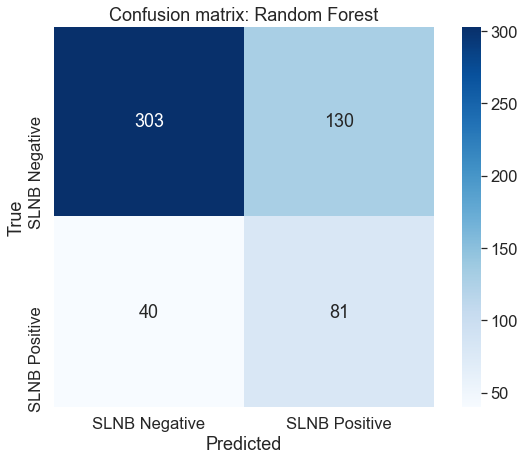

In [636]:
cm = confusion_matrix(y_test_sel, y_pred_sel)
df_cm = pd.DataFrame(cm, index = [i for i in ["SLNB Negative","SLNB Positive"]],
                  columns = [i for i in ["SLNB Negative","SLNB Positive"]])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True, cmap='Blues',square=True, fmt='d').set_title('Confusion matrix: Random Forest')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig(BASE_DIR+'../image/confusion_matrix.pdf')

In [637]:
303/(303+130)

0.6997690531177829

In [638]:
# pickling model
with open(BASE_DIR+'../model/balanced_rf_augmented_allknnimputed_binned.pkl', 'wb') as f:
    pkl.dump(rf, f)

In [639]:
# pickling preprocess pipeline
with open(BASE_DIR+'../model/preprocessor.pkl', 'wb') as f:
    pkl.dump(preprocessor, f)

## Need to adjust the threshold

In [676]:
# play with decision threshold
def adjusted_classes(y_scores, t):
    return np.where(y_scores > t, 1, 0)
#     return np.asarray([1 if y >= t else 0 for y in y_scores])

In [659]:
y_prob_sel = np.asarray(rf.predict_proba(X_test_sel))
y_pred_sel = adjusted_classes(y_prob_sel[:,1], 0.3)
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % accuracy_score(y_test_sel, y_pred_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

test accuracy: 0.2851985559566787
test NPV: 0.9302325581395349
test Precision: 0.2309197651663405
test Recall: 0.9752066115702479
test AUC: 0.7208119405264063
test F1: 0.37341772151898733
test AUPR: 0.4289795595402939


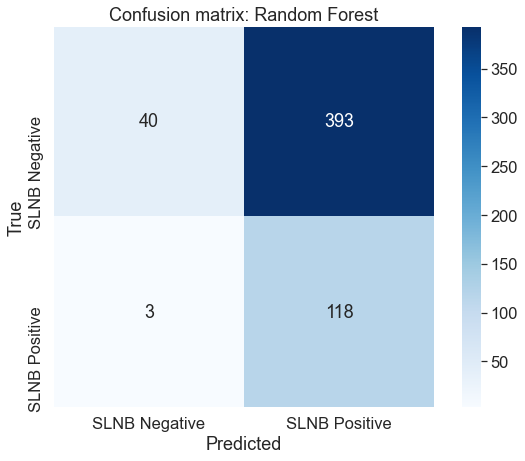

In [661]:
cm = confusion_matrix(y_test_sel, y_pred_sel)
df_cm = pd.DataFrame(cm, index = [i for i in ["SLNB Negative","SLNB Positive"]],
                  columns = [i for i in ["SLNB Negative","SLNB Positive"]])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True, cmap='Blues',square=True, fmt='d').set_title('Confusion matrix: Random Forest')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("../image/conf_matrix_30.png")

## Do not balance the data, instead adjust the decision threshold

In [712]:
# train a random forest classifier
rf = RandomForestClassifier(oob_score=True, 
                            random_state=123,
                            class_weight='balanced'
                           ) # set seed to ensure reproducibility
rf.fit(X_train_sel,y_train_sel.ravel())
y_prob_sel = np.asarray(rf.predict_proba(X_test_sel))
y_pred_sel = adjusted_classes(y_prob_sel[:,1], 0.05)
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % accuracy_score(y_test_sel, y_pred_sel))
# print("balanced accuracy: %s" % rf.score(X_test_sel, y_test_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test F2: %s" % fbeta_score(y_test_sel, y_pred_sel, beta=2))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

test accuracy: 0.3628158844765343
test NPV: 0.925531914893617
test Precision: 0.24782608695652175
test Recall: 0.9421487603305785
test AUC: 0.6657187028801558
test F1: 0.39242685025817553
test F2: 0.603813559322034
test AUPR: 0.3408446449771799


In [860]:
# RandomForest + Bayesian optimization
opt_rf = BayesSearchCV(RandomForestClassifier(oob_score=True,
                                     random_state=123,
                                     class_weight = 'balanced'
                                             ),
                       {
                        'n_estimators': (100,500),
                        'max_depth': (10, 50),  
                        'criterion': ['gini','entropy'],
                        'max_features': (3,22),
                       }, 
                        n_iter = 20, verbose = 5, 
                       scoring=make_scorer(adjusted_neg_Fbeta_score, 
                                           needs_proba=True, 
                                           beta=0.1, 
                                           threshold=0.1),
                       n_jobs=6)

# callback handler
def on_step(optim_result):
    score = opt_rf.best_score_
    print("best score: %s" % score)
#     with open("./rf_checkpoint.pkl", 'wb') as pickle_file:
#         pkl.dump(opt_rf, pickle_file)
    if score >= 0.99:
        print('Interrupting...')
        return True
    
opt_rf.fit(X_train_sel, y_train_sel.ravel(), callback=[on_step])

print("best parameter set: %s" % opt_rf.best_params_)
print("val. score: %s" % opt_rf.best_score_)
# print("test score: %s" % opt_rf.score(X_test, y_test))
y_prob_sel = np.asarray(opt_rf.predict_proba(X_test_sel))
y_pred_sel = adjusted_classes(y_prob_sel[:,1], 0.1)
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % accuracy_score(y_test_sel, y_pred_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test F2: %s" % fbeta_score(y_test_sel, y_pred_sel, beta=2))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.7s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.5s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.8410100967900249
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    2.3s remaining:    3.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.3s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.8410100967900249
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    2.3s remaining:    3.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.4s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.847550692382079
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    2.4s remaining:    3.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.4s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.847550692382079
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    2.9s remaining:    4.3s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.9s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.8485876161762059
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.8s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.8485876161762059
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    4.3s remaining:    6.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    4.4s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.8493588904904736
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.0s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.8493588904904736
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    1.0s finished


best score: 0.8493588904904736
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    3.5s remaining:    5.3s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    3.6s finished


best score: 0.850108482311
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    5.8s remaining:    8.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    5.9s finished


best score: 0.850108482311
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    1.2s finished


best score: 0.850108482311
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    8.2s remaining:   12.3s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    8.3s finished


best score: 0.850108482311
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    9.1s remaining:   13.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    9.2s finished


best score: 0.850108482311
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    3.9s remaining:    5.9s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    4.0s finished


best score: 0.850108482311
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    2.8s remaining:    4.1s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.8s finished


best score: 0.850108482311
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.1s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.1s finished


best score: 0.8566969450359618
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    3.5s remaining:    5.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    3.5s finished


best score: 0.8566969450359618
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    8.6s remaining:   12.9s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    8.8s finished


best score: 0.8566969450359618
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    7.4s remaining:   11.1s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    7.5s finished


best score: 0.8566969450359618
best parameter set: OrderedDict([('criterion', 'gini'), ('max_depth', 17), ('max_features', 20), ('n_estimators', 148)])
val. score: 0.8566969450359618
test accuracy: 0.37906137184115524
test NPV: 0.9009009009009009
test Precision: 0.24830699774266365
test Recall: 0.9090909090909091
test AUC: 0.6748038860153074
test F1: 0.3900709219858156
test F2: 0.593311758360302
test AUPR: 0.37103514964584117


In [863]:
# train a random forest classifier
rf = RandomForestClassifier(
                            criterion='gini', # entropy
                            max_depth=17,#37, 50 
                            max_features=20,#11, 5
                            n_estimators=148,#150, 43
                            oob_score=True, 
                            random_state=123,# set seed to ensure reproducibility
                            class_weight='balanced'
                           ) 
rf.fit(X_train_sel,y_train_sel.ravel())
y_prob_sel = np.asarray(rf.predict_proba(X_test_sel))
y_pred_sel = adjusted_classes(y_prob_sel[:,1], 0.1)
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % accuracy_score(y_test_sel, y_pred_sel))
# print("balanced accuracy: %s" % rf.score(X_test_sel, y_test_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test F2: %s" % fbeta_score(y_test_sel, y_pred_sel, beta=2))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

test accuracy: 0.37906137184115524
test NPV: 0.9009009009009009
test Precision: 0.24830699774266365
test Recall: 0.9090909090909091
test AUC: 0.6748038860153074
test F1: 0.3900709219858156
test F2: 0.593311758360302
test AUPR: 0.37103514964584117


In [864]:
y_prob_sel

array([[0.94374505, 0.05625495],
       [0.92708708, 0.07291292],
       [0.47042674, 0.52957326],
       ...,
       [0.82445158, 0.17554842],
       [0.91797563, 0.08202437],
       [0.96621622, 0.03378378]])

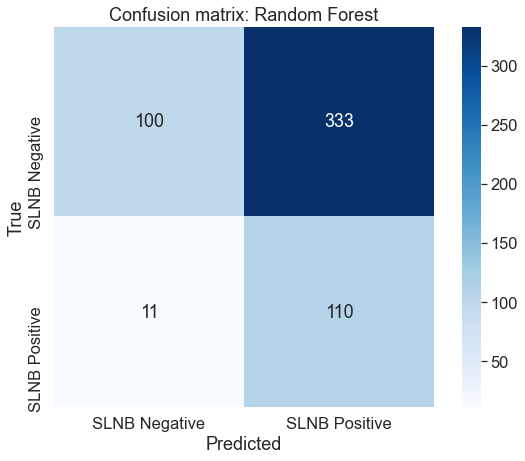

In [865]:
cm = confusion_matrix(y_test_sel, y_pred_sel)
df_cm = pd.DataFrame(cm, index = [i for i in ["SLNB Negative","SLNB Positive"]],
                  columns = [i for i in 
                             ["SLNB Negative","SLNB Positive"]])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True, cmap='Blues',square=True, fmt='d').set_title('Confusion matrix: Random Forest')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("../image/conf_matrix_10.png")

In [866]:
# pickling model
with open(BASE_DIR+'../model/rf_bias_augmented_allknnimputed_binned.pkl', 'wb') as f:
    pkl.dump(rf, f)

## Impute categorical vars using simpleImputer

In [4]:
# read in data
mcc_ncdb = pd.read_pickle(BASE_DIR + '../data/Merkel_NCDB_augmented_clean.pkl')
# subset of features only
mcc_ncdb_sel = mcc_ncdb[['AGE','SEX','PRIMARY_SITE',
                        'TUMOR_SIZE', 'DEPTH', 
                        'LYMPH_VASCULAR_INVASION', 
                        'TUMOR_INFILTRATING_LYMPHOCYTES',
                        'IMMUNE_SUPPRESSION', 
                        'GROWTH_PATTERN',
                        'TUMOR_BASE_TRANSECTION',
                        'SLNB'
                       ]]


In [5]:
mcc_ncdb_sel.head()

,AGE,SEX,PRIMARY_SITE,TUMOR_SIZE,DEPTH,LYMPH_VASCULAR_INVASION,TUMOR_INFILTRATING_LYMPHOCYTES,IMMUNE_SUPPRESSION,GROWTH_PATTERN,TUMOR_BASE_TRANSECTION,SLNB
8,71,1,C444,10,999.0,0,999,999,999,999,0.0
12,87,1,C447,999,999.0,9,999,999,999,999,1.0
14,43,1,C443,2,10.0,9,0,0,999,20,0.0
19,59,2,C447,25,50.0,0,999,999,999,999,0.0
21,75,2,C446,30,999.0,9,999,999,999,999,1.0


In [6]:
mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'].value_counts()

999.0    7217
10.0     1159
20.0      988
0.0       526
Name: TUMOR_BASE_TRANSECTION, dtype: int64

In [7]:
# binning the categories
mcc_ncdb_sel.loc[:,'SEX'] = mcc_ncdb_sel['SEX'].replace([1, 2],
                                                ['Male', 'Female']
#                                                   [0,1]
                                               )
mcc_ncdb_sel.loc[:,'PRIMARY_SITE'] = mcc_ncdb_sel['PRIMARY_SITE'].replace(['C440','C441','C442','C443',
                                                                     'C444','C445','C446','C447',
                                                                     'C448','C449'],
                                                                    ['Head_and_Neck',
                                                                     'Head_and_Neck',
                                                                     'Head_and_Neck',
                                                                     'Other',
                                                                     'Head_and_Neck',
                                                                     'Trunk',
                                                                     'Extremity',
                                                                     'Extremity',
                                                                     'Other',
                                                                     'Other']
#                                                                     [0,0,0,3,0,1,2,2,3,3]
                                                                   )
mcc_ncdb_sel.loc[:,'LYMPH_VASCULAR_INVASION'] = mcc_ncdb_sel['LYMPH_VASCULAR_INVASION'].replace([0, 1, 8, 9],
                                                                                          ['No',
                                                                                           'Yes',
                                                                                           np.nan,
                                                                                           np.nan
                                                                                          ]
#                                                                                          [0,1,np.nan,np.nan]
                                                                                         )
mcc_ncdb_sel.loc[:,'TUMOR_INFILTRATING_LYMPHOCYTES'] = mcc_ncdb_sel['TUMOR_INFILTRATING_LYMPHOCYTES'].replace(
                                                                                          [0, 10, 20, 30, 999],
                                                                                          ['Negative',
                                                                                           'Weak',
                                                                                           'Strong',
                                                                                           'Present',
                                                                                           np.nan
                                                                                          ]
#                                                                                         [0,1,2,3,np.nan]
                                                                                        )
mcc_ncdb_sel.loc[:,'IMMUNE_SUPPRESSION'] = mcc_ncdb_sel['IMMUNE_SUPPRESSION'].replace(
                                                                              [0, 10, 20, 30, 40,
                                                                               50, 60, 70, 999],
                                                                              ['Negative',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               np.nan
                                                                              ]
#                                                                                 [0,1,1,1,1,1,1,1,np.nan]
                                                                            )
mcc_ncdb_sel.loc[:,'GROWTH_PATTERN'] = mcc_ncdb_sel['GROWTH_PATTERN'].replace([10, 20, 999],
                                                                          ['Circumscribed_nodular',
                                                                           'Diffusely_infiltrative',
                                                                           np.nan]
#                                                                         [0,1,np.nan]
                                                                        )

mcc_ncdb_sel.loc[:,'TUMOR_BASE_TRANSECTION'] = mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'].replace([0, 10, 20, 999],
                                                                                          ['Not_found',
                                                                                           'Transected',
                                                                                           'Not_transected',
                                                                                           np.nan
                                                                                          ]
#                                                                                         [0,1,2,np.nan]
                                                                                       )

mcc_ncdb_sel.loc[:,'DEPTH'] = mcc_ncdb_sel['DEPTH'].replace([999],np.nan)
mcc_ncdb_sel.loc[:,'TUMOR_SIZE'] = mcc_ncdb_sel['TUMOR_SIZE'].replace([999],np.nan)

/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


## Count how many rows have missing value in all except AGE, SEX, PRIMARY_SITE, SLNB (indicating that they are not useful at all)

In [8]:
# mcc_ncdb_sel_count = mcc_ncdb_sel.drop(['AGE','SEX','PRIMARY_SITE','SLNB'], axis=1)
# mcc_ncdb_sel.drop(mcc_ncdb_sel_count.index[mcc_ncdb_sel_count.isnull().all(1)], axis=0)
# mcc_ncdb_sel.dropna(thresh=7)
print(mcc_ncdb_sel.dropna(thresh=6).SLNB.value_counts()) # make threshold = 6 i.e. at max 5 NaN
mcc_ncdb_sel.dropna(thresh=6, inplace=True)

0.0    4394
1.0    1146
Name: SLNB, dtype: int64


/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## Imputing numeric using kNN and categorical using simpleImputer (most frequent)

In [9]:
mcc_ncdb_sel.head()

,AGE,SEX,PRIMARY_SITE,TUMOR_SIZE,DEPTH,LYMPH_VASCULAR_INVASION,TUMOR_INFILTRATING_LYMPHOCYTES,IMMUNE_SUPPRESSION,GROWTH_PATTERN,TUMOR_BASE_TRANSECTION,SLNB
8,71,Male,Head_and_Neck,10.0,NaN,No,NaN,NaN,NaN,NaN,0.0
14,43,Male,Other,2.0,10.0,NaN,Negative,Negative,NaN,Not_transected,0.0
19,59,Female,Extremity,25.0,50.0,No,NaN,NaN,NaN,NaN,0.0
23,82,Female,Other,14.0,NaN,No,NaN,Negative,Circumscribed_nodular,Not_transected,0.0
31,90,Male,Extremity,15.0,62.0,No,NaN,NaN,NaN,Not_transected,0.0


In [10]:
X_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns != 'SLNB'])
y_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns == 'SLNB'])

In [11]:
X_sel

array([[71, 'Male', 'Head_and_Neck', ..., nan, nan, nan],
       [43, 'Male', 'Other', ..., 'Negative', nan, 'Not_transected'],
       [59, 'Female', 'Extremity', ..., nan, nan, nan],
       ...,
       [32, 'Male', 'Head_and_Neck', ..., nan, nan, nan],
       [35, 'Male', 'Other', ..., 'Negative', nan, 'Transected'],
       [37, 'Male', 'Head_and_Neck', ..., nan, 'Circumscribed_nodular',
        'Transected']], dtype=object)

In [12]:
from sklearn.base import BaseEstimator,TransformerMixin

class RoundTransformer(BaseEstimator,TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.round()
 

In [13]:
# from sklearn.metrics.pairwise import check_pairwise_arrays
# def nan_hamming_distances(X, Y, metric, force_all_finite=True, missing_values=np.nan, **kwds):
#     """Handle the callable case for pairwise_{distances,kernels}.
#     """
#     X, Y = check_pairwise_arrays(X, Y, force_all_finite=force_all_finite)

#     if X is Y:
#         # Only calculate metric for upper triangle
#         out = np.zeros((X.shape[0], Y.shape[0]), dtype='float')
#         iterator = itertools.combinations(range(X.shape[0]), 2)
#         for i, j in iterator:
#             out[i, j] = metric(X[i], Y[j], **kwds)

#         # Make symmetric
#         # NB: out += out.T will produce incorrect results
#         out = out + out.T

#         # Calculate diagonal
#         # NB: nonzero diagonals are allowed for both metrics and kernels
#         for i in range(X.shape[0]):
#             x = X[i]
#             out[i, i] = metric(x, x, **kwds)

#     else:
#         # Calculate all cells
#         out = np.empty((X.shape[0], Y.shape[0]), dtype='float')
#         iterator = itertools.product(range(X.shape[0]), range(Y.shape[0]))
#         for i, j in iterator:
#             out[i, j] = metric(X[i], Y[j], **kwds)

#     return out

In [14]:
### combined pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler

numeric_columns = [0,3,4]
cat_columns = [1,2,5,6,7,8,9]

# logTransformer = FunctionTransformer(np.log1p, validate=True)
numeric_pipeline = make_pipeline(KNNImputer(), RoundTransformer())
cat_pipeline     = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(sparse=False))

ct = [
        ('num', numeric_pipeline, numeric_columns),
        ('cat', cat_pipeline, cat_columns)
     ]

preprocessor = Pipeline(steps=[
        ('col_transformers',ColumnTransformer(ct, remainder='passthrough'))
    ])

X_sel = preprocessor.fit_transform(X_sel)

In [15]:
# split data
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, y_sel, 
                                                                test_size = 0.1, 
                                                                random_state = 123) # set seed to ensure reproducibility

In [16]:
X_train_sel.shape

(4986, 22)

In [17]:
X_train_sel[1]

array([ 54.,  20., 110.,   0.,   1.,   1.,   0.,   0.,   0.,   1.,   0.,
         1.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   1.,   0.,   0.])

In [19]:
# play with decision threshold
def adjusted_classes(y_scores, t):
    return np.where(y_scores > t, 1, 0)

In [954]:
# train a random forest classifier
rf = RandomForestClassifier(oob_score=True, 
                            random_state=123,
                            class_weight='balanced'
                           ) # set seed to ensure reproducibility
rf.fit(X_train_sel,y_train_sel.ravel())
y_prob_sel = np.asarray(rf.predict_proba(X_test_sel))
y_pred_sel = adjusted_classes(y_prob_sel[:,1], 0.1)
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % accuracy_score(y_test_sel, y_pred_sel))
# print("balanced accuracy: %s" % rf.score(X_test_sel, y_test_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test F2: %s" % fbeta_score(y_test_sel, y_pred_sel, beta=2))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

test accuracy: 0.4927797833935018
test NPV: 0.9042553191489362
test Precision: 0.2814207650273224
test Recall: 0.8512396694214877
test AUC: 0.6715591777527534
test F1: 0.42299794661190965
test F2: 0.6058823529411765
test AUPR: 0.35186489373704166


In [955]:
# RandomForest + Bayesian optimization
opt_rf = BayesSearchCV(RandomForestClassifier(oob_score=True,
                                     random_state=123,
                                     class_weight = 'balanced'
                                             ),
                       {
                        'n_estimators': (100,2000),
                        'max_depth': (3, 50),  
                        'criterion': ['gini','entropy'],
                        'max_features': (10,22),
                       }, 
                        n_iter = 20, verbose = 5, 
                       scoring=make_scorer(adjusted_neg_Fbeta_score, 
                                           needs_proba=True, 
                                           beta=0.2, 
                                           threshold=0.1),
                       n_jobs=6)

# callback handler
def on_step(optim_result):
    score = opt_rf.best_score_
    print("best score: %s" % score)
#     with open("./rf_checkpoint.pkl", 'wb') as pickle_file:
#         pkl.dump(opt_rf, pickle_file)
    if score >= 0.99:
        print('Interrupting...')
        return True
    
opt_rf.fit(X_train_sel, y_train_sel.ravel(), callback=[on_step])

print("best parameter set: %s" % opt_rf.best_params_)
print("val. score: %s" % opt_rf.best_score_)
# print("test score: %s" % opt_rf.score(X_test, y_test))
y_prob_sel = np.asarray(opt_rf.predict_proba(X_test_sel))
y_pred_sel = adjusted_classes(y_prob_sel[:,1], 0.1)
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % accuracy_score(y_test_sel, y_pred_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test F2: %s" % fbeta_score(y_test_sel, y_pred_sel, beta=2))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    5.9s remaining:    8.8s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    5.9s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.0
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   12.0s remaining:   18.0s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   12.5s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.018711134767240775
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    4.4s remaining:    6.7s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    4.5s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.815845833443858
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   13.7s remaining:   20.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   13.9s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.8179842763379652
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   17.4s remaining:   26.1s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   17.5s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.8179842763379652
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   20.4s remaining:   30.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   20.5s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.8179842763379652
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    2.8s remaining:    4.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.9s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.8179842763379652
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    5.0s remaining:    7.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    5.1s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.8179842763379652
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   21.2s remaining:   31.8s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   21.5s finished


best score: 0.8179842763379652
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   29.2s remaining:   43.9s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   29.7s finished


best score: 0.8182717964316414
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    1.1s finished


best score: 0.8193581236218208
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    1.8s finished


best score: 0.8201617853315498
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   29.8s remaining:   44.7s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   30.2s finished


best score: 0.8201617853315498
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   18.8s remaining:   28.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   19.0s finished


best score: 0.8201617853315498
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    1.5s finished


best score: 0.8201617853315498
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   21.2s remaining:   31.8s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   21.5s finished


best score: 0.8205081509616282
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    1.1s finished


best score: 0.8205081509616282
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    1.2s finished


best score: 0.8205081509616282
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    1.0s finished


best score: 0.8205081509616282
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    1.1s finished


best score: 0.8208736811207378
best parameter set: OrderedDict([('criterion', 'entropy'), ('max_depth', 31), ('max_features', 10), ('n_estimators', 100)])
val. score: 0.8208736811207378
test accuracy: 0.48014440433212996
test NPV: 0.9050279329608939
test Precision: 0.2773333333333333
test Recall: 0.859504132231405
test AUC: 0.6908079323573759
test F1: 0.41935483870967744
test F2: 0.6053550640279395
test AUPR: 0.34646389461573357


In [26]:
# train a random forest classifier
rf = RandomForestClassifier(
                            criterion='entropy',# gini # entropy
                            max_depth=31,#42, 37, 50 
                            max_features=10,#10, 11, 5
                            n_estimators=100,#100, 150, 43
                            oob_score=True, 
                            random_state=123,# set seed to ensure reproducibility
                            class_weight='balanced'
                           ) 
rf.fit(X_train_sel,y_train_sel.ravel())
y_prob_sel = np.asarray(rf.predict_proba(X_test_sel))
y_pred_sel = adjusted_classes(y_prob_sel[:,1], 0.1)
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % accuracy_score(y_test_sel, y_pred_sel))
# print("balanced accuracy: %s" % rf.score(X_test_sel, y_test_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test F2: %s" % fbeta_score(y_test_sel, y_pred_sel, beta=2))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

test accuracy: 0.48014440433212996
test NPV: 0.9050279329608939
test Precision: 0.2773333333333333
test Recall: 0.859504132231405
test AUC: 0.6908079323573759
test F1: 0.41935483870967744
test F2: 0.6053550640279395
test AUPR: 0.34646389461573357


In [39]:
X_sel[0]

array([71., 10., 87.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,
        0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.])

In [966]:
y_prob_sel[:,1]

array([0.03885436, 0.11      , 0.32562962, 0.12068992, 0.18      ,
       0.43      , 0.06679861, 0.11      , 0.44      , 0.21      ,
       0.19      , 0.09732111, 0.36      , 0.17794424, 0.45658959,
       0.11      , 0.58      , 0.        , 0.03      , 0.42      ,
       0.06      , 0.36417942, 0.29      , 0.38      , 0.04      ,
       0.09      , 0.19      , 0.18      , 0.03794424, 0.17223567,
       0.29      , 0.23      , 0.26      , 0.4       , 0.1       ,
       0.08      , 0.37      , 0.1       , 0.27      , 0.11      ,
       0.28      , 0.18      , 0.11      , 0.1       , 0.20885436,
       0.2       , 0.04      , 0.21355693, 0.04      , 0.06      ,
       0.03      , 0.1698527 , 0.69      , 0.13885436, 0.46      ,
       0.14      , 0.11      , 0.26093791, 0.09      , 0.02      ,
       0.14794424, 0.23      , 0.01794424, 0.03      , 0.12      ,
       0.12      , 0.12425319, 0.03      , 0.1       , 0.25794424,
       0.15435945, 0.42      , 0.02      , 0.1       , 0.34   

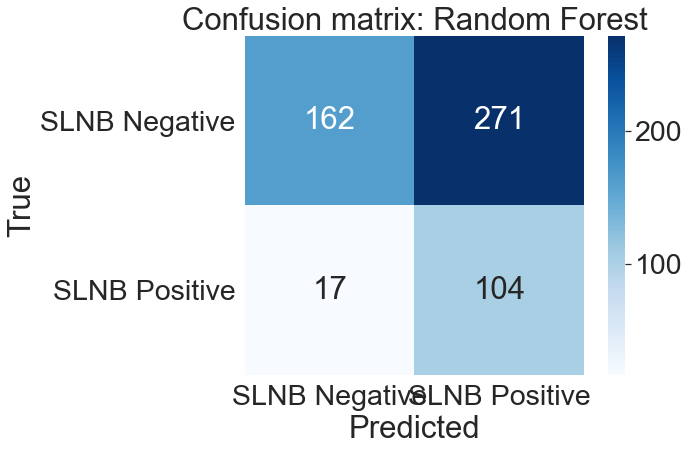

In [37]:
# sns.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20, "axes.ticksize": 20})   
sns.set(font_scale=2.6)
cm = confusion_matrix(y_test_sel, y_pred_sel)
df_cm = pd.DataFrame(cm, index = [i for i in ["SLNB Negative","SLNB Positive"]],
                  columns = [i for i in 
                             ["SLNB Negative","SLNB Positive"]])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True, cmap='Blues',square=True, fmt='d').set_title('Confusion matrix: Random Forest')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("../image/conf_matrix_10_sepImpute.png")

In [962]:
# pickling model
with open(BASE_DIR+'../model/rf_bias_augmented_sepknnimputed_binned.pkl', 'wb') as f:
    pkl.dump(rf, f)

In [963]:
# pickling preprocess pipeline
with open(BASE_DIR+'../model/preprocessor_sepImpute.pkl', 'wb') as f:
    pkl.dump(preprocessor, f)

In [965]:
162/(162+271)

0.3741339491916859

In [34]:
y_pred_sel_baseline = np.ones(len(y_test_sel))

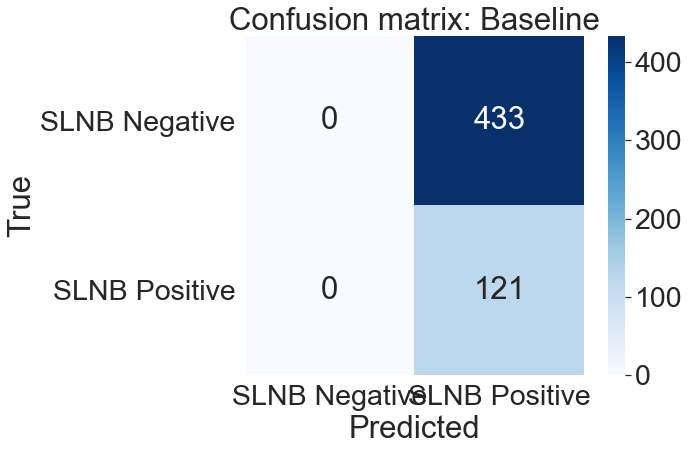

In [36]:
sns.set(font_scale=2.6)
cm = confusion_matrix(y_test_sel, y_pred_sel_baseline)
df_cm = pd.DataFrame(cm, index = [i for i in ["SLNB Negative","SLNB Positive"]],
                  columns = [i for i in 
                             ["SLNB Negative","SLNB Positive"]])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True, cmap='Blues',square=True, fmt='d').set_title('Confusion matrix: Baseline')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("../image/conf_matrix_baseline.png")

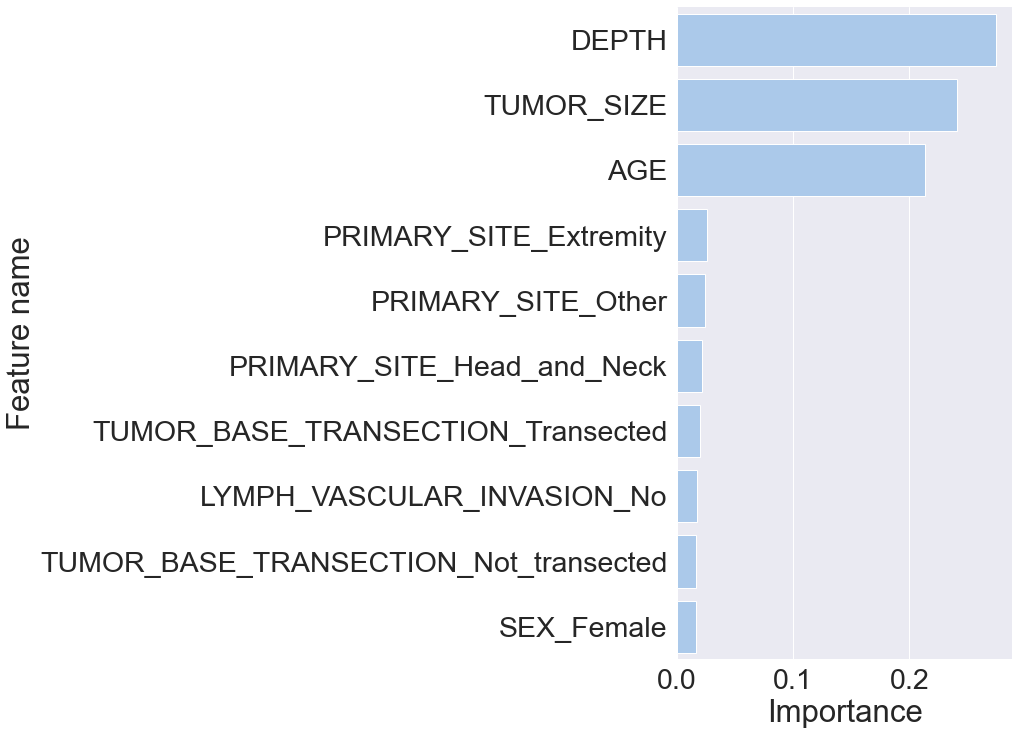

In [40]:
# feature importances
feature_names = ['AGE', 'TUMOR_SIZE', 'DEPTH', 'SEX_Female', 'SEX_Male',
       'PRIMARY_SITE_Extremity', 'PRIMARY_SITE_Head_and_Neck',
       'PRIMARY_SITE_Other', 'PRIMARY_SITE_Trunk',
       'LYMPH_VASCULAR_INVASION_No', 'LYMPH_VASCULAR_INVASION_Yes', 
       'TUMOR_INFILTRATING_LYMPHOCYTES_Negative',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Present',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Strong',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Weak',
       'IMMUNE_SUPPRESSION_Negative', 'IMMUNE_SUPPRESSION_Positive',
       'GROWTH_PATTERN_Circumscribed_nodular',
       'GROWTH_PATTERN_Diffusely_infiltrative',
       'TUMOR_BASE_TRANSECTION_Not_found',
       'TUMOR_BASE_TRANSECTION_Not_transected',
       'TUMOR_BASE_TRANSECTION_Transected']
imp = rf.feature_importances_
imp_df = pd.DataFrame(data={"Feature name": feature_names,
                      "Importance": imp}
                     ).sort_values("Importance", ascending=False).head(10)

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 12))
sns.set_color_codes("pastel")
sns.barplot(x="Importance", y="Feature name", data=imp_df, color="b")
sns.despine(left=True, bottom=True)
plt.savefig(BASE_DIR+'../image/feature_importance_10_sepImpute.png', bbox_inches='tight')

In [ ]:
## ROC curve

## Try training with calibration

In [14]:
from sklearn.base import BaseEstimator,TransformerMixin,MetaEstimatorMixin,ClassifierMixin

class RoundTransformer(BaseEstimator,TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.round()

class PassthroughTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        self.X = X
        return X

    def get_feature_names(self):
        return self.X.columns.tolist()

class PredictionTransformer(BaseEstimator, TransformerMixin, MetaEstimatorMixin):
    def __init__(self, clf):
        """Replaces all features with `clf.predict_proba(X)`"""
        self.clf = clf
    
    def fit(self, X, y):
        self.clf.fit(X, y)
        return self
    
    def transform(self, X):
        return self.clf.predict_proba(X)


class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, threshold=0.5):
        """Classify samples based on whether they are above of below `threshold`"""
        self.threshold = threshold

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        return self
    
    def predict(self, X):
        # the implementation used here breaks ties differently
        # from the one used in RFs:
        #return self.classes_.take(np.argmax(X, axis=1), axis=0)
        return np.where(X[:, 0]>self.threshold, *self.classes_)

In [15]:
def adjusted_classes(y_scores, t):
    return np.where(y_scores > t, 1, 0)

In [16]:
def negative_pred_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN = cm[0][0]
    FN = cm[1][0]
    return TN/(TN+FN)

In [17]:
def adjusted_negative_pred_value(y_true, y_prob, threshold):
    # first get adjusted hard class
    y_pred = np.where(y_prob>threshold, 1, 0)
    cm = confusion_matrix(y_true, y_pred)
    TN = cm[0][0]
    FN = cm[1][0]
    if TN+FN == 0:
        NPV = 0
    else:
        NPV = TN/(TN+FN)
    return NPV

In [18]:
def adjusted_F1_score(y_true, y_prob, threshold):
    # first get adjusted hard class
    y_pred = np.where(y_prob>threshold, 1, 0)
    cm = confusion_matrix(y_true, y_pred)
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = 2*precision*recall/(precision+recall)
    return F1

In [19]:
def adjusted_neg_F1_score(y_true, y_prob, threshold):
    # first get adjusted hard class
    y_pred = np.where(y_prob>threshold, 1, 0)
    cm = confusion_matrix(y_true, y_pred)
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
    if TN+FN == 0:
        NPV = 0
    else:
        NPV = TN/(TN+FN)
    if TN+FP == 0:
        specificity = 0
    else:
        specificity = TN/(TN+FP)
        
    if NPV+specificity == 0:
        F1 = 0
    else:
        F1 = 2*NPV*specificity/(NPV+specificity)
    return F1

In [20]:
def adjusted_neg_Fbeta_score(y_true, y_prob, beta, threshold):
    # first get adjusted hard class
    y_pred = np.where(y_prob>threshold, 1, 0)
    cm = confusion_matrix(y_true, y_pred)
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
    if TN+FN == 0:
        NPV = 0
    else:
        NPV = TN/(TN+FN)
    if TN+FP == 0:
        specificity = 0
    else:
        specificity = TN/(TN+FP)
        
    if NPV+specificity == 0:
        Fb = 0
    else:
        Fb = (1+beta**2)*NPV*specificity/((beta**2)*NPV+specificity)
    return Fb